In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import PIL

import shutil

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Using PyTorch version 1.6.0
Random Seed:  999


In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):#pass class name
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')] #get list of image
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name) #get images that belong each class 
            
        self.image_dirs = image_dirs #saveing 
        self.transform = transform #saveing 
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    # the main fuction ( to make balance in the data)
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) # to avoide aout of bounds
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name) # return image, lable

In [5]:
# Root directory for dataset
dataroot = "/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 20 #128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Image Transformations

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64, 64)),#convert size to resnet 18 
    #torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(), #convert image to tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize image 
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 590 covid examples


In [8]:
test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


# Prepare DataLoader

In [9]:
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test)) #15*6=90


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



Number of training batches 161
Number of test batches 5


# Data Visualization

In [10]:
class_names = train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Testing Images")
    plt.imshow(np.transpose(vutils.make_grid(images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# DCGAN Network

In [11]:
def normal_init(layer, mean, std):
    if type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
        torch.nn.init.normal_(layer.weight.data, mean, std)
        


In [12]:
labels = ['normal', 'viral', 'covid']

## 1) Generator Code

In [13]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

ngpu = 1

n_classes = 3

class Generator(nn.Module):
            
    def __init__(self):
        super(Generator, self).__init__()
        self.embeddingLabel = nn.Embedding(3, 50)
        self.LIN1 = nn.Linear(50, 256)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0) # 512 x 4 x 4
        self.BN1 = nn.BatchNorm2d(ngf * 8)
        self.conv2 = nn.ConvTranspose2d(ngf * 8 , ngf * 4, 4, 2, 1) # 256 x 8 x 8
        self.BN2 = nn.BatchNorm2d(ngf * 4)
        self.conv5 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1) # 128 x 16 x 16
        self.BN5 = nn.BatchNorm2d(ngf * 2)
        self.conv3 = nn.ConvTranspose2d(ngf * 2+1 , ngf * 1, 4, 2, 1) # 64 x 32 x 32
        self.BN3 = nn.BatchNorm2d(ngf * 1)
        self.conv4 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1) # 3 x 64 x 64
#         self.BN4 = nn.BatchNorm2d(ngf)
#         self.conv5 = nn.ConvTranspose2d(ngf + 1, nc, 4, 2, 1)
        nn.Tanh()
    
    
    # forward method
    def forward(self, input, labels):
        x = F.relu(self.BN1(self.conv1(input)))
        x = F.relu(self.BN2(self.conv2(x)))
        x = F.relu(self.BN5(self.conv5(x)))
        y = self.LIN1(self.embeddingLabel(labels))
        y = y.view(-1, 1, 16, 16)
        y = torch.cat([x,y], 1)
        x = F.relu(self.BN3(self.conv3(y)))
        x = self.conv4(x)
#         x = F.relu(self.BN4(self.conv4(y)))
#         x = self.conv5(x)
        x = F.tanh(x)
        return x
    
    # weight_init
    def weight_init(self, mean=0, std=0.02):
        normal_init(self, mean, std)


In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embeddingLabel = nn.Embedding(3, 50)
        self.LIN1 = nn.Linear(50, 256)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1) # 3 x 64 x 64
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1) # 64 x 32 x 32
        self.BN1 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2+1, ndf * 4, 4, 2, 1) # 128 x 16 x 16
        self.BN2 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1) # 256 x 8 x 8
        self.BN3 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0) # 512 x 4 x 4
        nn.Sigmoid() # 100 x 1

    # forward method
    def forward(self, input, labels):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.BN1(self.conv2(x)), 0.2)
        y = self.LIN1(self.embeddingLabel(labels))
        y = y.view(-1, 1, 16, 16)
        y = torch.cat([x,y], 1)
        x = F.leaky_relu(self.BN2(self.conv3(y)), 0.2)
        
        x = F.leaky_relu(self.BN3(self.conv4(x)), 0.2)
        
        x = self.conv5(x)
        x = F.sigmoid(x)
        return x
    
    # weight_init
    def weight_init(self, mean=0, std=0.02):
        normal_init(self, mean, std)


In [15]:
grid_size = 6
device = torch.device("cuda:0")

fixed_z = torch.randn(6*6, 100, 1, 1, device=device)

# output generated samples from the current state of the generator network
def show_result(num_epoch, show=False, save=False, grid_size=6, path = 'result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z).cpu()
        else:
            #  generate a new random noise vector
            z = fixed_z
            fake = G(z).cpu()

        fig, ax = plt.subplots(figsize=(8, 8))
        
        image = utils.make_grid(fake.data, grid_size, 1)
        
        plt.imshow(np.transpose(image, (1, 2, 0)))    
        ax.axis('off')
        plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [16]:
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(netG.weight_init)

# Print the model

Generator(
  (embeddingLabel): Embedding(3, 50)
  (LIN1): Linear(in_features=50, out_features=256, bias=True)
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (BN1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(129, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [17]:
# Create the Discriminator
netD = Discriminator().to(device)

# Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(netD.weight_init)

# Print the model
print(netD)

Discriminator(
  (embeddingLabel): Embedding(3, 50)
  (LIN1): Linear(in_features=50, out_features=256, bias=True)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(129, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BN3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)


In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(256, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:

n_samples = 5
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0")
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
number_of_generated_images = 10
 
#######################################################################################################
fixed_z = Variable(FloatTensor(np.random.normal(0, 1, (number_of_generated_images, 100))).view(-1,100,1,1))
# Create 6 times for each class/label
# fixed_labels = Variable(LongTensor(np.array([i for _ in range(6) for i in range(3)])))
fixed_labels = Variable(LongTensor(np.random.randint(0, 3, number_of_generated_images)))
def show_conditional_result(num_epoch, show=False, save=False, n_classes=3, n_samples=5, path='result.png', useFixed=False):
    with torch.no_grad():
#         print("Hi")
        if useFixed:   
            fake = G(fixed_z, fixed_labels).cpu()
        else:
            #  generate a new random noise vector and a grid of labels
            z = fixed_z
            labels = fixed_labels

            fake = G(z, labels).cpu()

        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1) 

        plt.imshow(np.transpose(image, (1, 2, 0)))
        normal_count = 0
        pneumonia_count = 0
        covid_count = 0
        tag = 0
        for i in range(fixed_labels.shape[0]):
#             fig, ax = plt.subplots(figsize=(20, 10))
            fixed_images = utils.make_grid(fake[i,:,:,:].data, n_classes, 1) 
            plt.imshow(np.transpose(fixed_images, (1, 2, 0)))
            if fixed_labels[i] == 0:
                folder = 'gen_normal'
                normal_count += 1
                tag = normal_count
            if fixed_labels[i] == 1:
                folder = 'gen_pneumonia'
                pneumonia_count += 1
                tag = pneumonia_count
            if fixed_labels[i] == 2:
                folder = 'gen_covid'
                covid_count += 1
                tag = covid_count
            #plt.savefig('{}/{}_{}.png'.format(folder,folder,epoch))
            plt.savefig('{}/{}_{}.png'.format(folder,folder,tag))

            
        ax.axis('off')
        print(fixed_labels)
        
        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()
            
                        
# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [26]:
batch_size = 20
num_epochs = 100
learning_rate = 0.0001 # need to adjust this



Training ...


/home/alsaedsb/.local/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/alsaedsb/.local/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/alsaedsb/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


loss_fake: tensor(0.8097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0716, de

loss_fake: tensor(9.0093e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.8458e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

/home/alsaedsb/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(1.2297e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [1 / 100] G loss: 12.518701553344727 D loss: 0.02610412985086441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


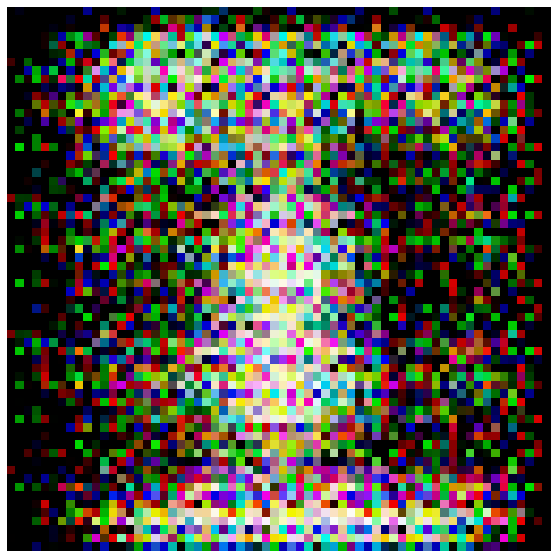

loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, de

loss_fake: tensor(0.1521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [2 / 100] G loss: 4.376236915588379 D loss: 0.1272171288728714


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


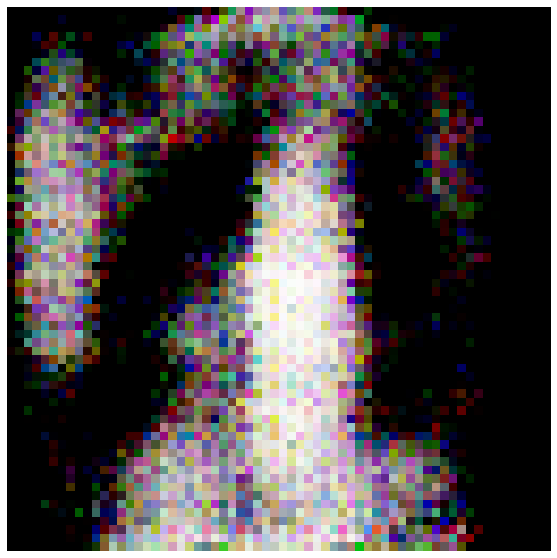

loss_fake: tensor(0.1528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1190, de

loss_fake: tensor(0.0186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1152, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [3 / 100] G loss: 2.8156185150146484 D loss: 0.24826887249946594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


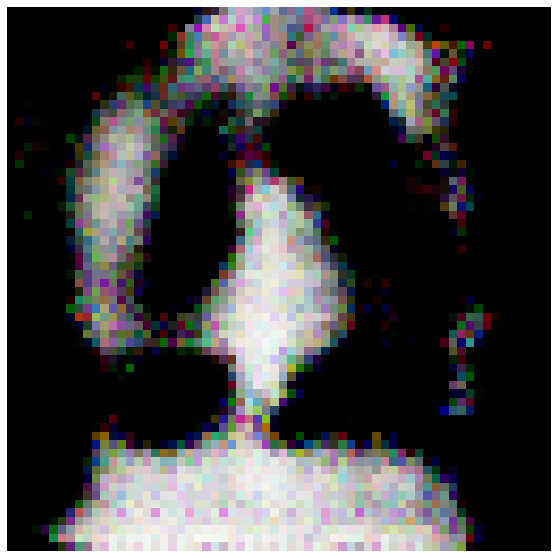

loss_fake: tensor(0.8856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3274, de

loss_fake: tensor(0.3254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0110, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [4 / 100] G loss: 2.864673376083374 D loss: 0.44425979256629944


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


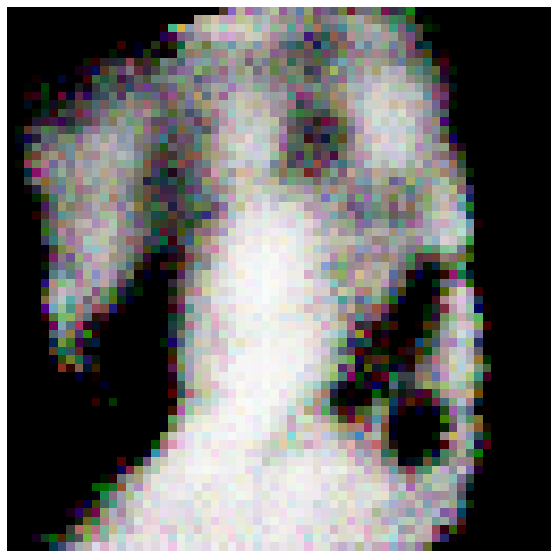

loss_fake: tensor(0.1346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0738, de

loss_fake: tensor(0.2829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.7561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0845, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [5 / 100] G loss: 4.500631809234619 D loss: 0.12512996792793274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


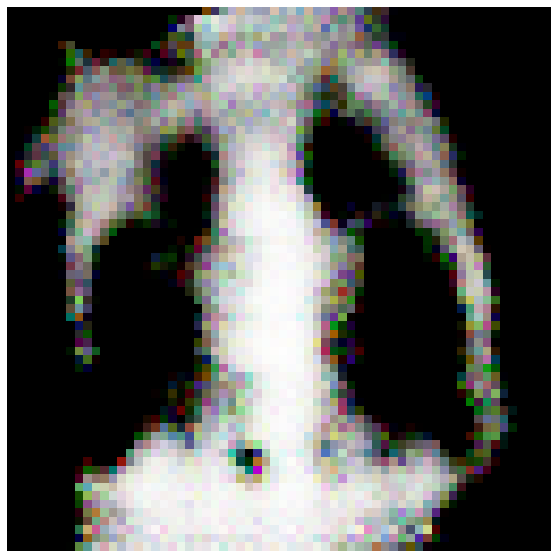

loss_fake: tensor(0.0442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.7019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1319, de

loss_fake: tensor(0.1202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2087, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.1534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [6 / 100] G loss: 2.938113212585449 D loss: 0.30611172318458557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


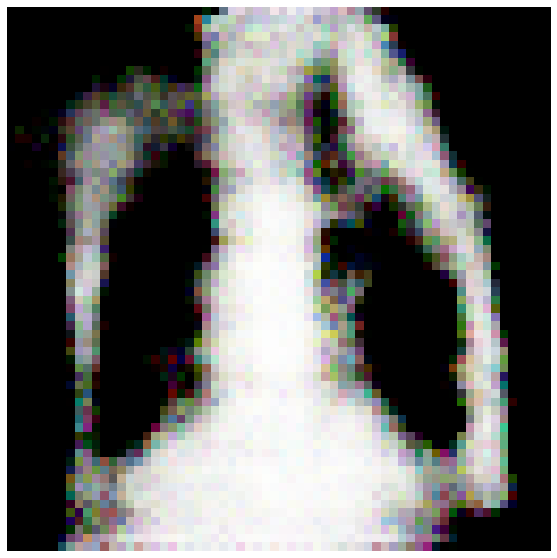

loss_fake: tensor(0.4913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0615, de

loss_fake: tensor(0.1473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0685, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0323, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [7 / 100] G loss: 4.44885778427124 D loss: 0.16802984476089478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


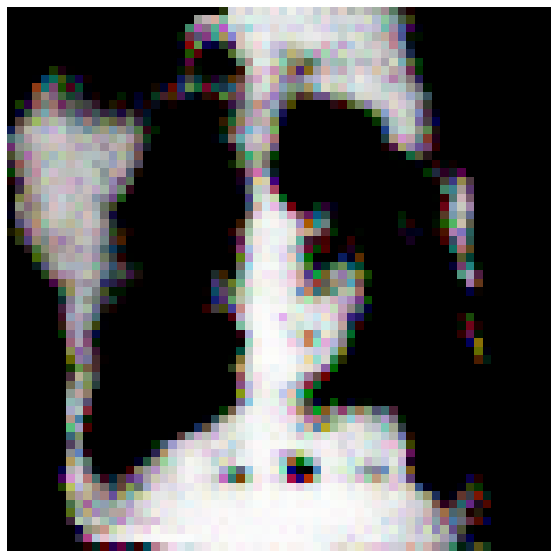

loss_fake: tensor(0.0841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0137, de

loss_fake: tensor(0.0759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.5605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [8 / 100] G loss: 9.301031112670898 D loss: 0.5691418051719666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


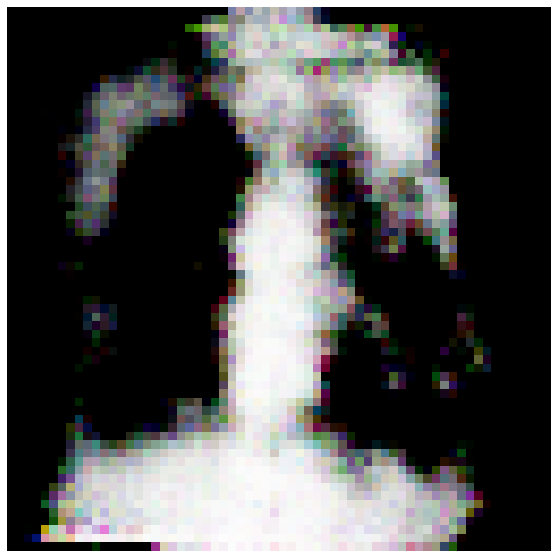

loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2212, de

loss_fake: tensor(0.2977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [9 / 100] G loss: 5.100593566894531 D loss: 0.42192399501800537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


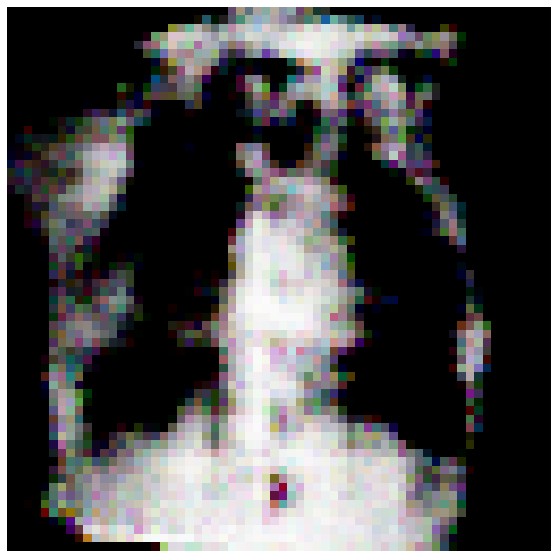

loss_fake: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0851, de

loss_fake: tensor(0.4851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0374, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [10 / 100] G loss: 5.168922424316406 D loss: 0.04041476547718048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


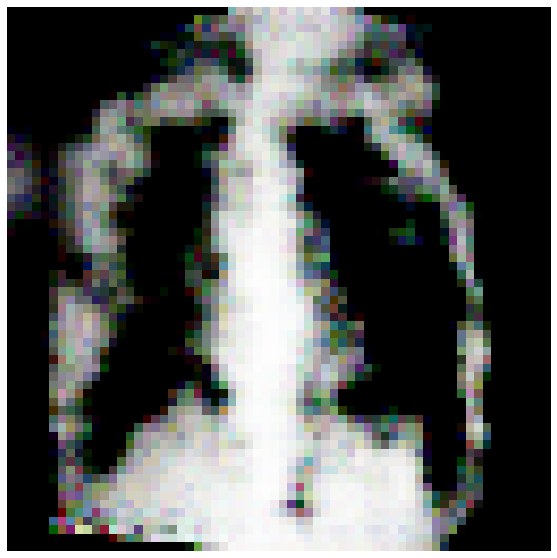

loss_fake: tensor(0.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0424, de

loss_fake: tensor(0.0414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.1637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [11 / 100] G loss: 5.316250324249268 D loss: 0.1690061390399933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


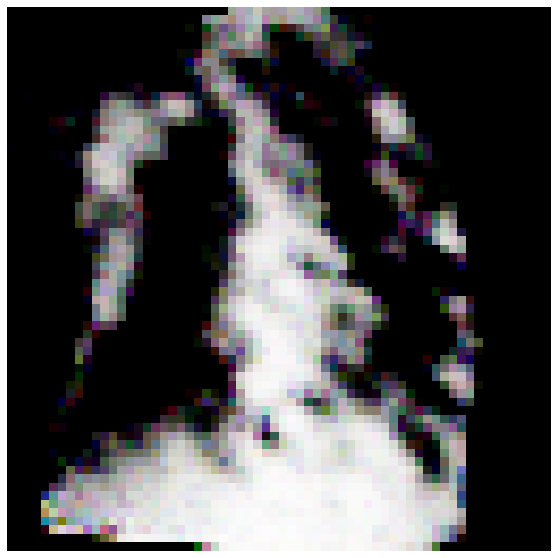

loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0166, de

loss_fake: tensor(0.1153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.9035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [12 / 100] G loss: 10.894989013671875 D loss: 0.930487334728241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


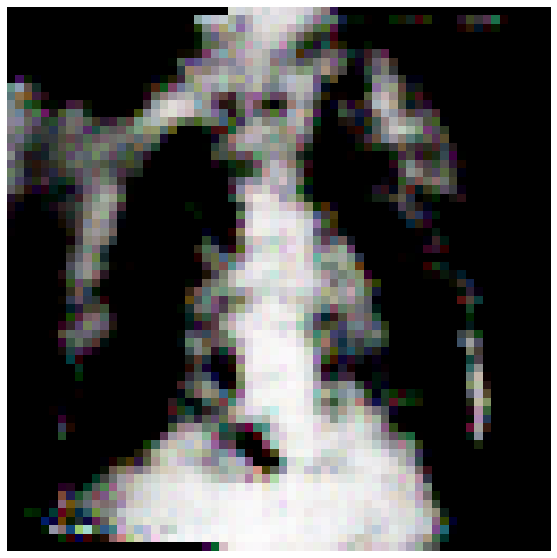

loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0683, de

loss_fake: tensor(0.0358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [13 / 100] G loss: 4.671643257141113 D loss: 0.07412908226251602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


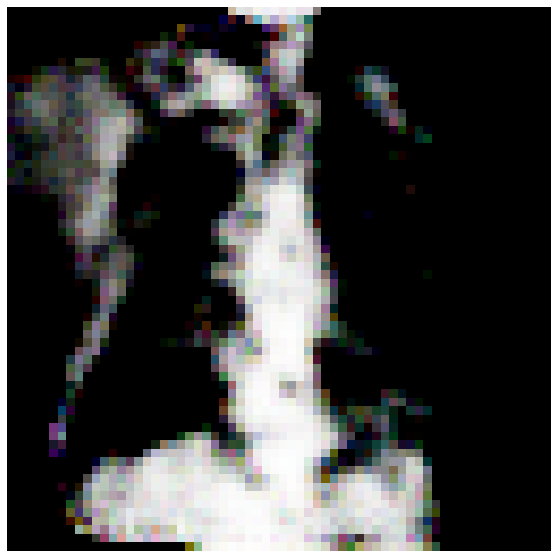

loss_fake: tensor(0.1001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, de

loss_fake: tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [14 / 100] G loss: 4.873379230499268 D loss: 0.10743621736764908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


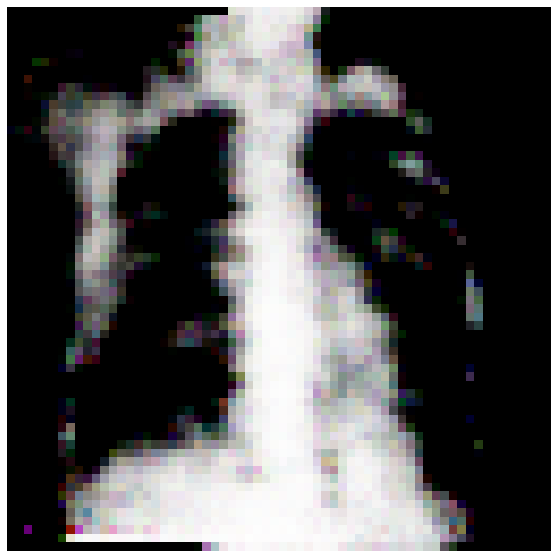

loss_fake: tensor(0.0336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0607, de

loss_fake: tensor(0.1069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [15 / 100] G loss: 4.548583030700684 D loss: 0.1635216772556305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


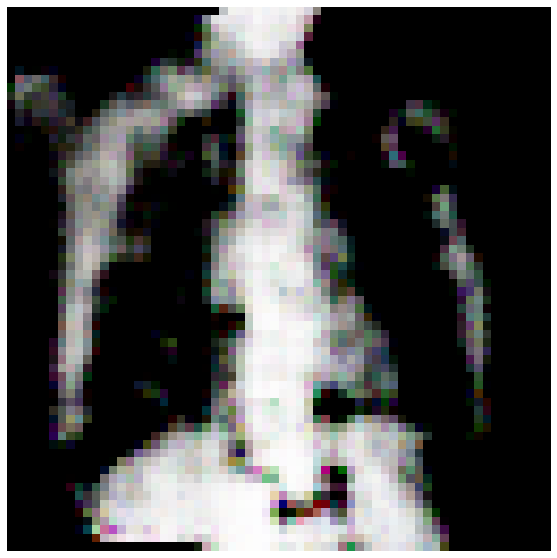

loss_fake: tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0127, de

loss_fake: tensor(0.0526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0156, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [16 / 100] G loss: 3.4983880519866943 D loss: 0.09658850729465485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


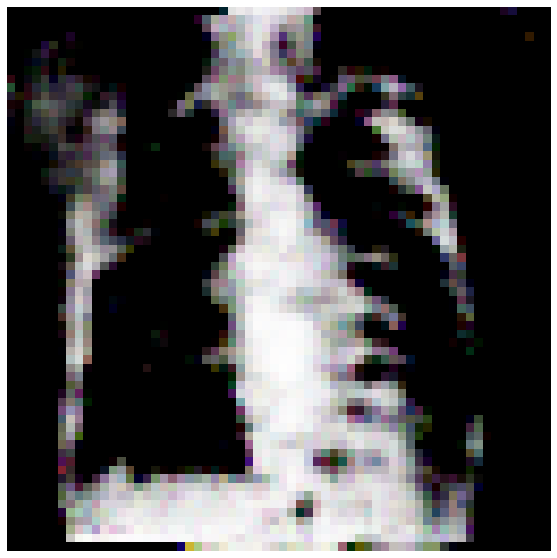

loss_fake: tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1303, de

loss_fake: tensor(0.0317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0736, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [17 / 100] G loss: 2.5583839416503906 D loss: 0.1869894415140152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


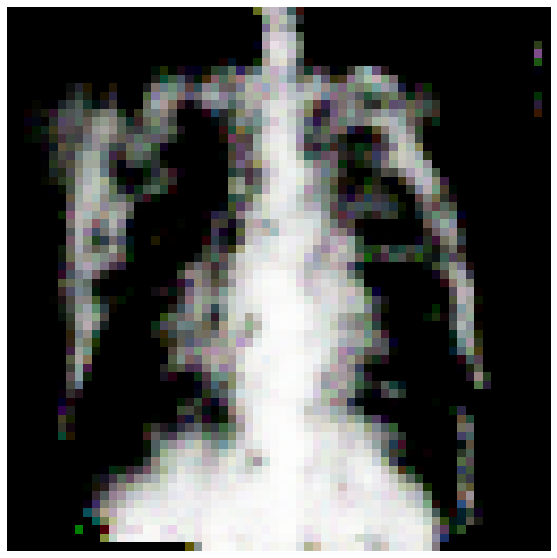

loss_fake: tensor(0.4554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0090, de

loss_fake: tensor(0.1339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.8490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0900, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [18 / 100] G loss: 5.0855937004089355 D loss: 0.04461418837308884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


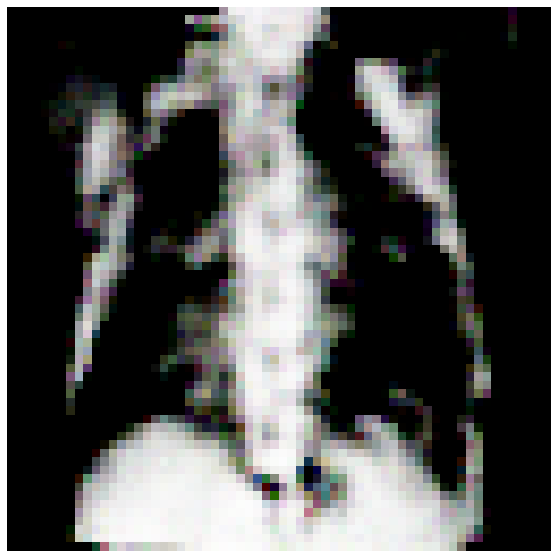

loss_fake: tensor(0.1209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1230, de

loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0403, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [19 / 100] G loss: 5.617344856262207 D loss: 0.092653788626194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


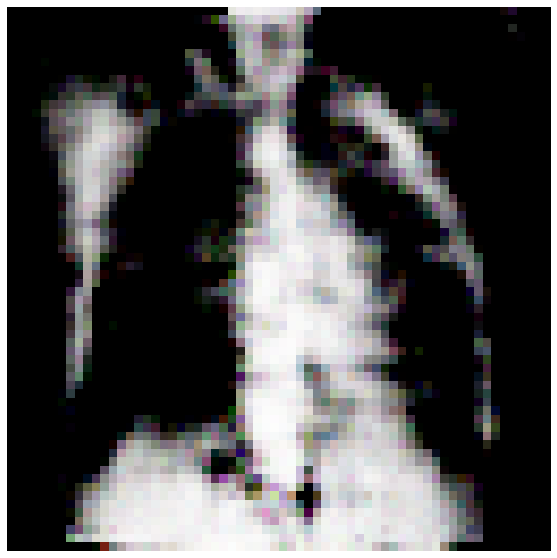

loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.3439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2613, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0646, de

loss_fake: tensor(0.0487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0068, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [20 / 100] G loss: 5.532987594604492 D loss: 0.018718158826231956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


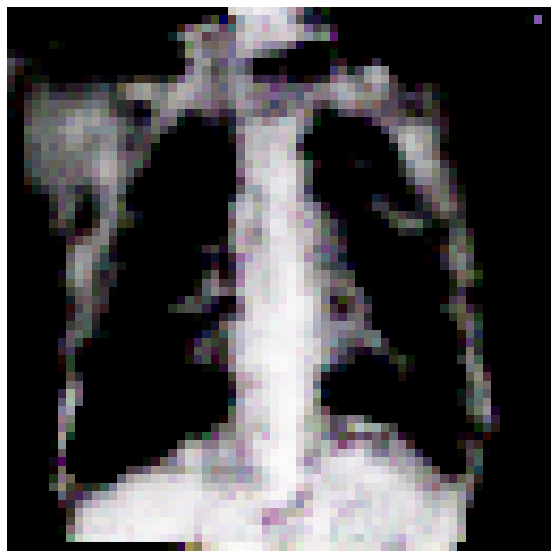

loss_fake: tensor(0.0214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, de

loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0539, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.8700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [21 / 100] G loss: 9.185358047485352 D loss: 0.8707406520843506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


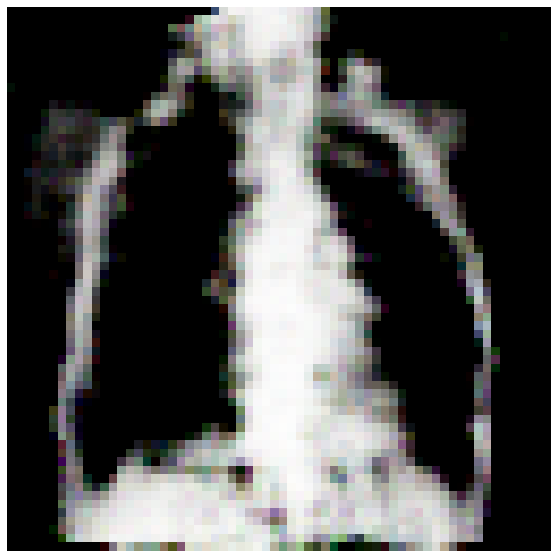

loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0570, de

loss_fake: tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1872, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.8087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [22 / 100] G loss: 7.484457015991211 D loss: 0.8104763031005859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


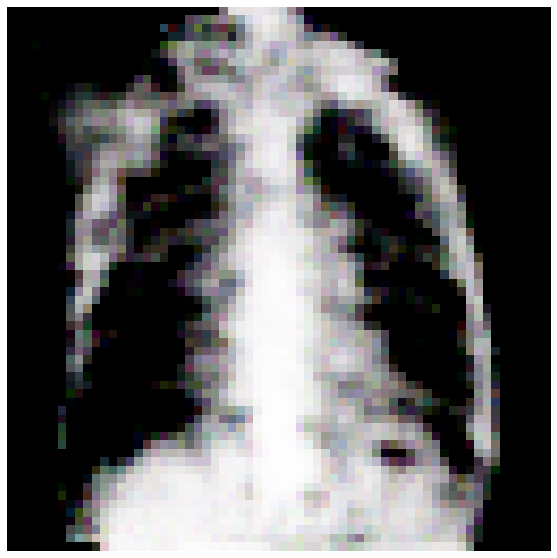

loss_fake: tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0516, de

loss_fake: tensor(0.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0341, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [23 / 100] G loss: 5.748353958129883 D loss: 0.23183095455169678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


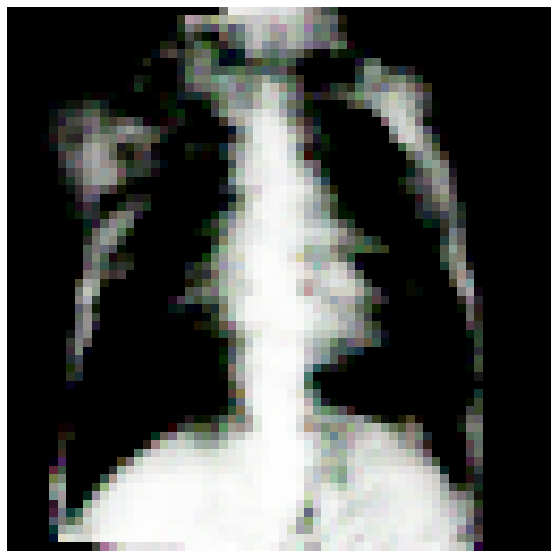

loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0158, de

loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [24 / 100] G loss: 5.2726874351501465 D loss: 0.025387365370988846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


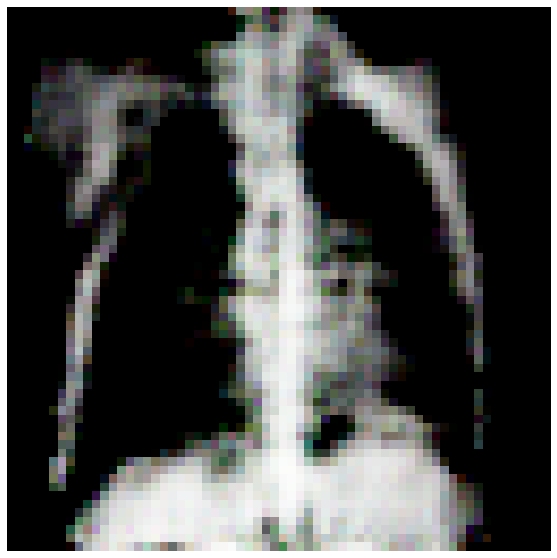

loss_fake: tensor(0.0921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, de

loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0952, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [25 / 100] G loss: 5.268793106079102 D loss: 0.243259996175766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


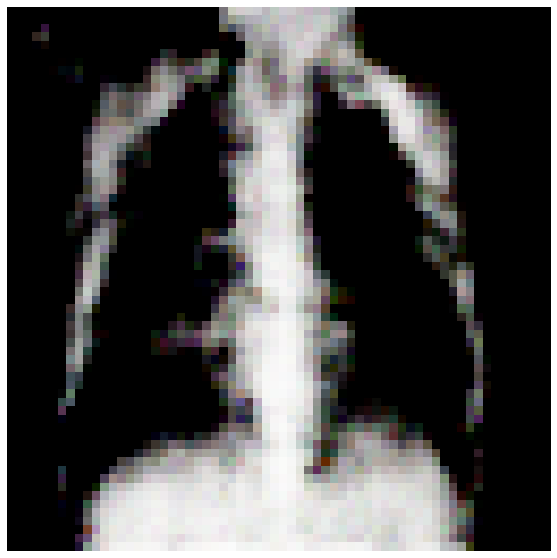

loss_fake: tensor(0.0481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, de

loss_fake: tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3027, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [26 / 100] G loss: 4.648735046386719 D loss: 0.08973206579685211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


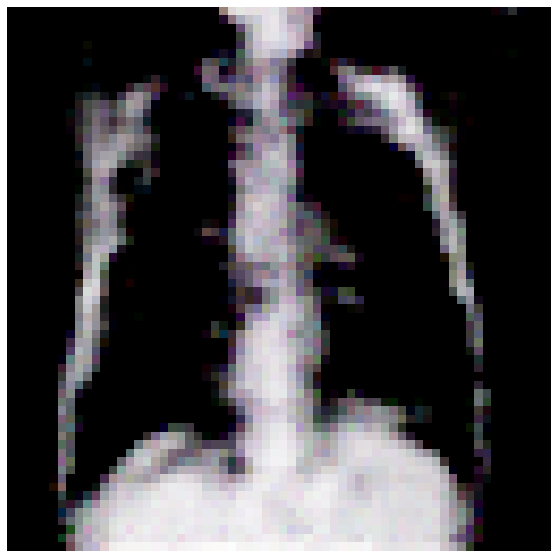

loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0081, de

loss_fake: tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0092, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [27 / 100] G loss: 5.459604740142822 D loss: 0.02882508374750614


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


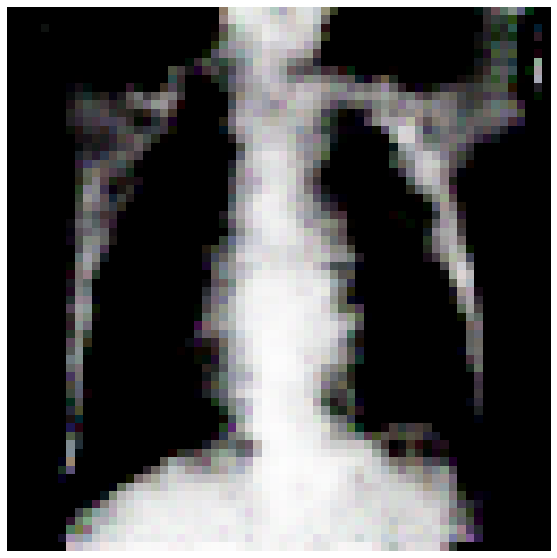

loss_fake: tensor(0.0872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0217, de

loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0289, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [28 / 100] G loss: 4.177764892578125 D loss: 0.06270039826631546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


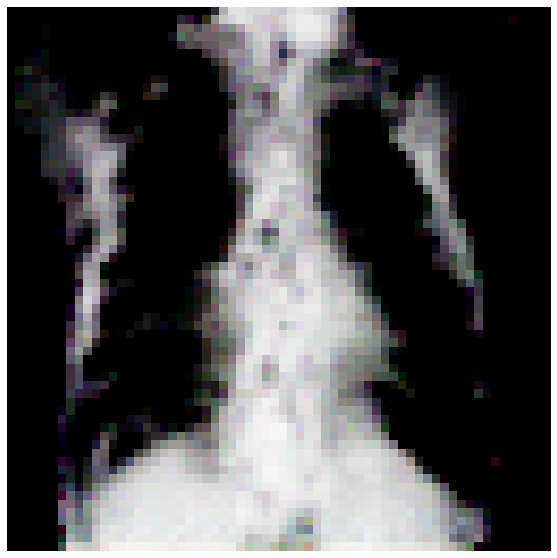

loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0200, de

loss_fake: tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.6927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0906, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [29 / 100] G loss: 4.758271217346191 D loss: 0.05928672105073929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


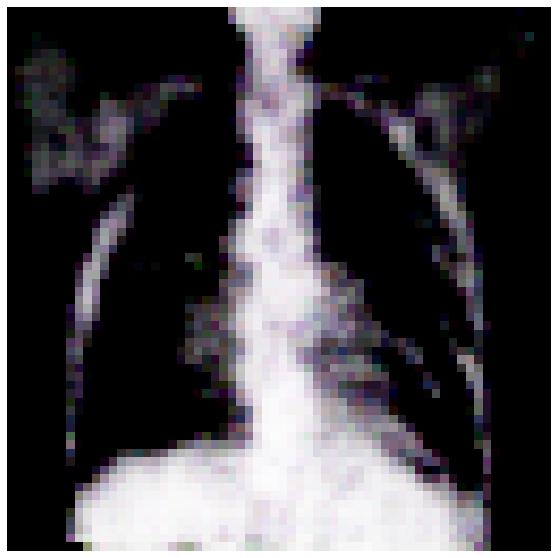

loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0253, de

loss_fake: tensor(0.0199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0266, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [30 / 100] G loss: 4.317665100097656 D loss: 0.1298428624868393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


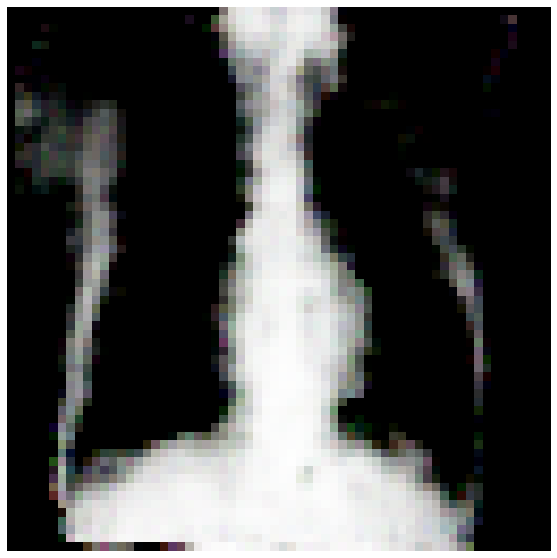

loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0230, de

loss_fake: tensor(0.0278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1183, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [31 / 100] G loss: 4.983726501464844 D loss: 0.08121176064014435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


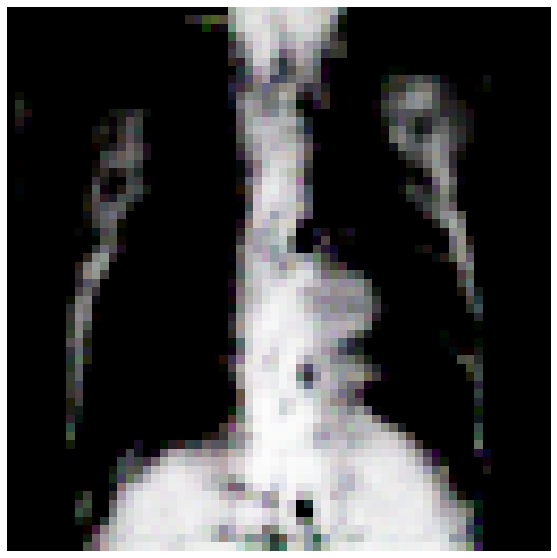

loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.2464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2312, de

loss_fake: tensor(0.1468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0918, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


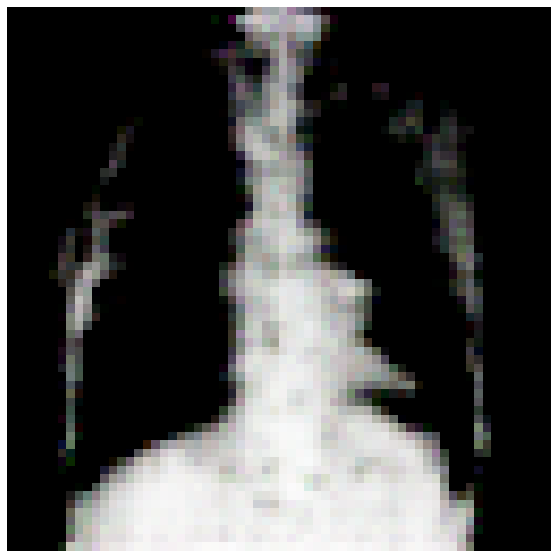

loss_fake: tensor(0.1271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, de

loss_fake: tensor(2.7442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(9.0959e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.0572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0218

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [33 / 100] G loss: 5.781015872955322 D loss: 0.07593460381031036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


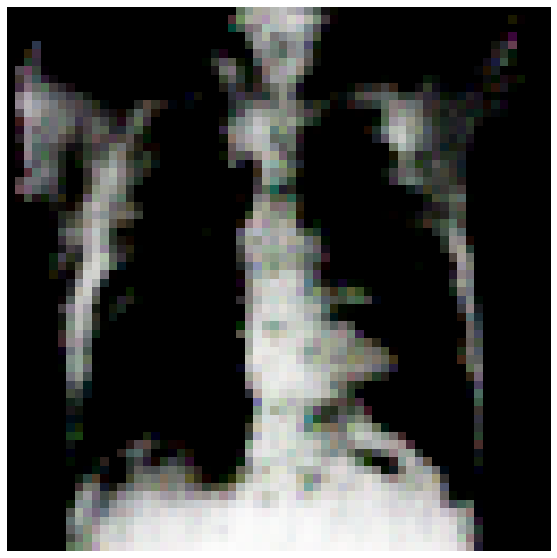

loss_fake: tensor(0.0098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0176, de

loss_fake: tensor(0.0824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0104, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [34 / 100] G loss: 3.758639335632324 D loss: 0.07254984229803085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


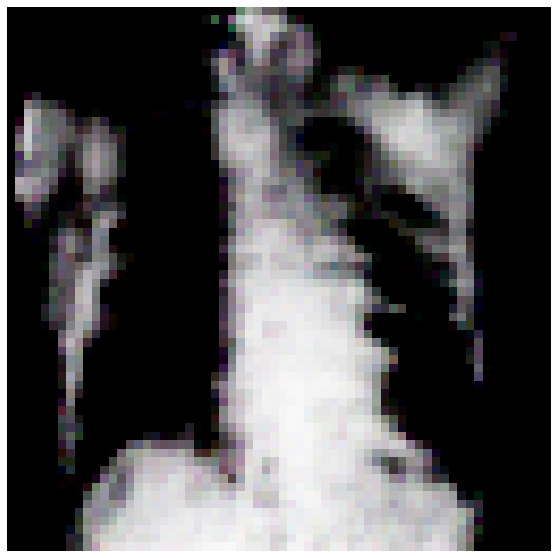

loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, de

loss_fake: tensor(0.2250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0159, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.2979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [35 / 100] G loss: 5.06195592880249 D loss: 0.3040940761566162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


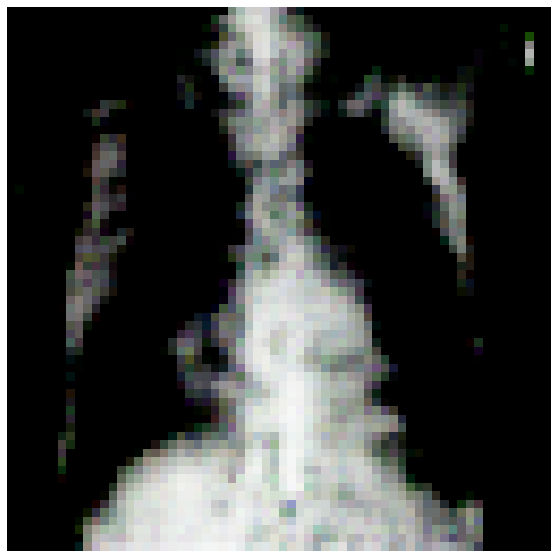

loss_fake: tensor(0.1115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, de

loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0525, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [36 / 100] G loss: 5.600679397583008 D loss: 0.02368595078587532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


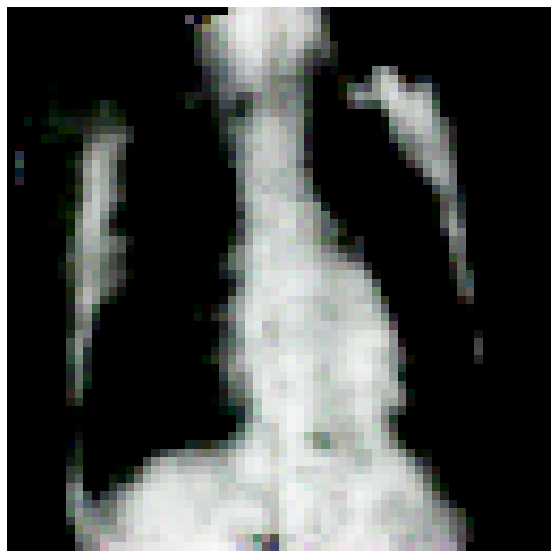

loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0730, de

loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [37 / 100] G loss: 2.9427900314331055 D loss: 0.08160602301359177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


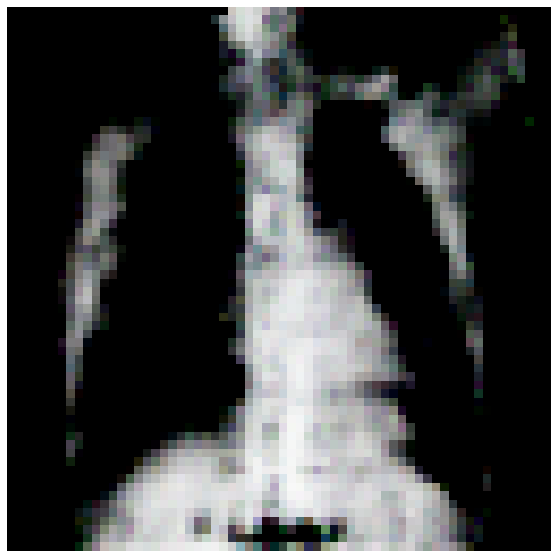

loss_fake: tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, de

loss_fake: tensor(1.1625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.8674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0513, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [38 / 100] G loss: 4.182168006896973 D loss: 0.19246436655521393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


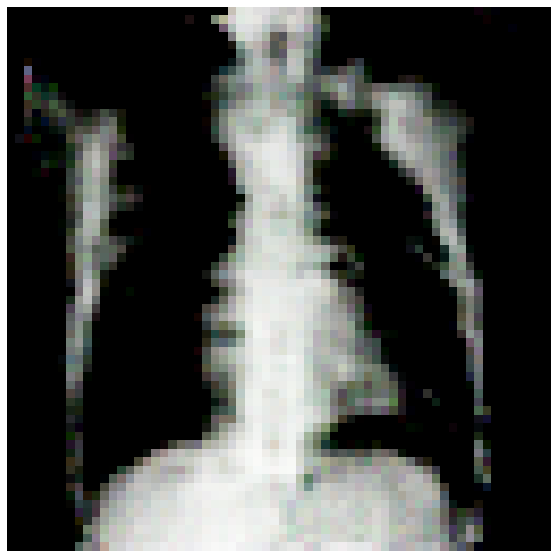

loss_fake: tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0200, de

loss_fake: tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [39 / 100] G loss: 5.205829620361328 D loss: 0.016169529408216476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


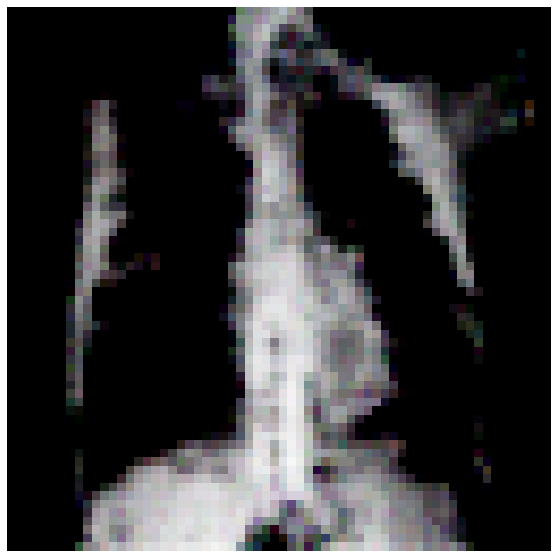

loss_fake: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0316, de

loss_fake: tensor(0.0360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0098, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [40 / 100] G loss: 4.62844181060791 D loss: 0.059654735028743744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


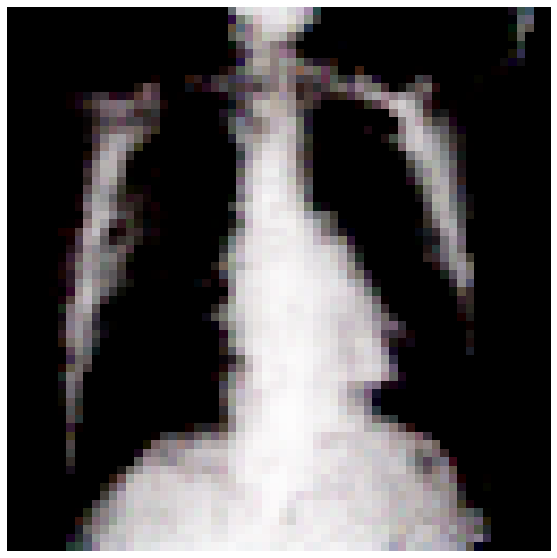

loss_fake: tensor(0.0162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.7797e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.7874e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0162, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [41 / 100] G loss: 5.039127349853516 D loss: 0.033702630549669266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


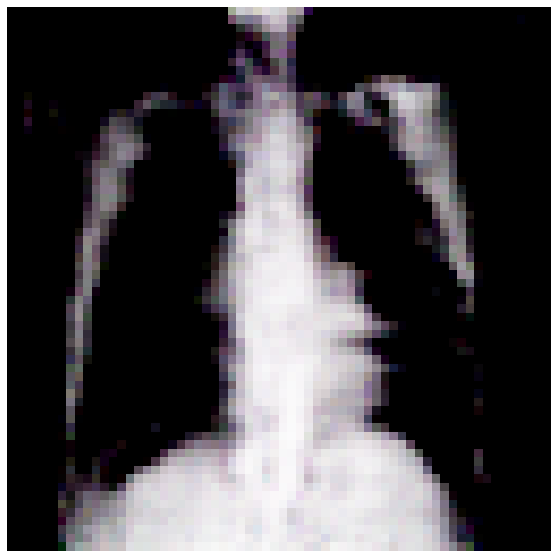

loss_fake: tensor(0.0200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, de

loss_fake: tensor(0.1786, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0232, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [42 / 100] G loss: 6.370987892150879 D loss: 0.053114987909793854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


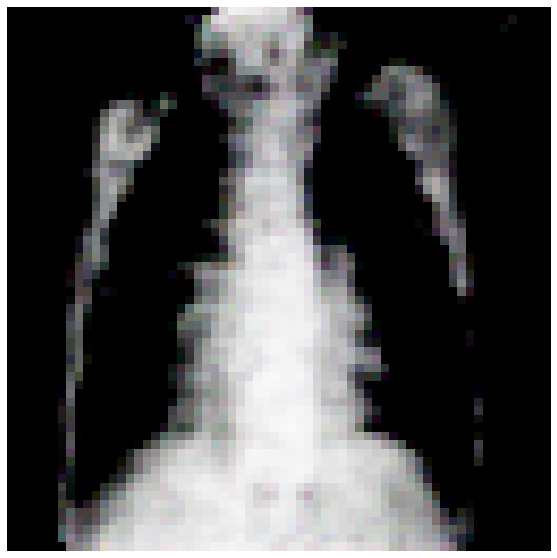

loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1093, de

loss_fake: tensor(0.0871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0088, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [43 / 100] G loss: 6.560659408569336 D loss: 0.10981465876102448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


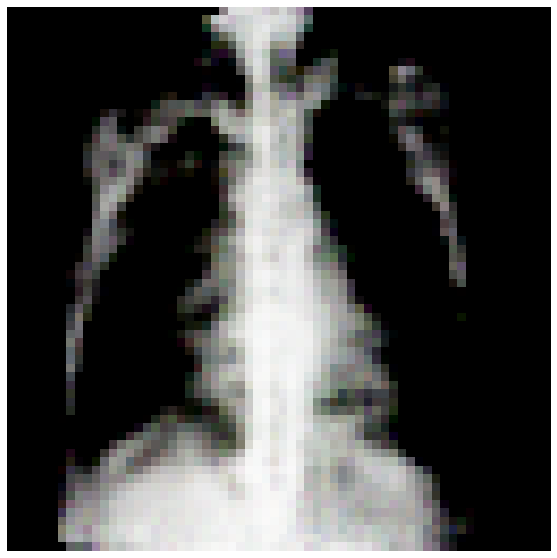

loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0128, de

loss_fake: tensor(0.1277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0319, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [44 / 100] G loss: 4.777218818664551 D loss: 0.17520233988761902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


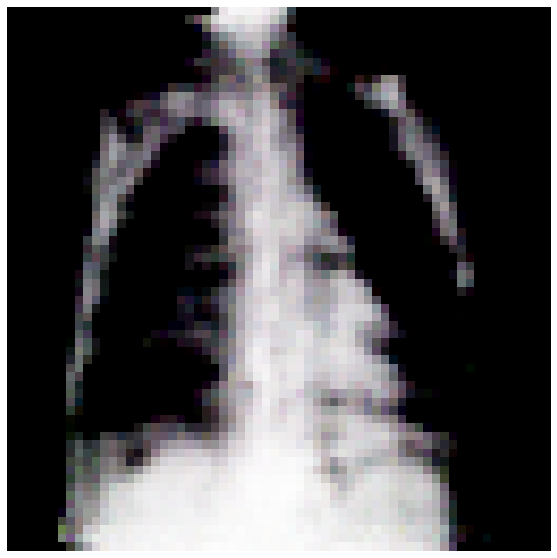

loss_fake: tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0201, de

loss_fake: tensor(0.2565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0832, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [45 / 100] G loss: 4.244384765625 D loss: 0.051193054765462875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


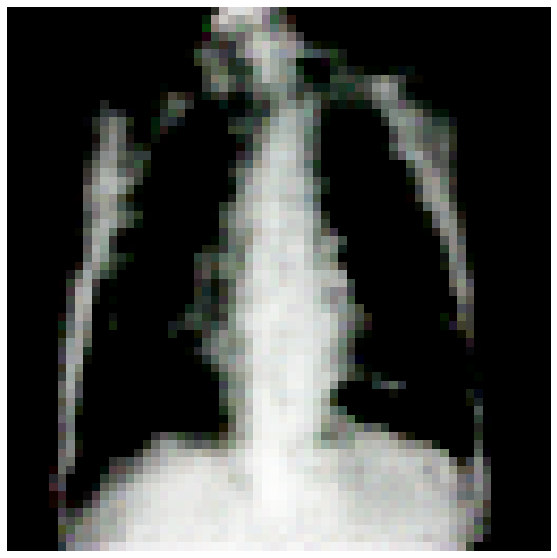

loss_fake: tensor(0.0948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0311, de

loss_fake: tensor(0.0331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [46 / 100] G loss: 5.553862571716309 D loss: 0.029726488515734673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


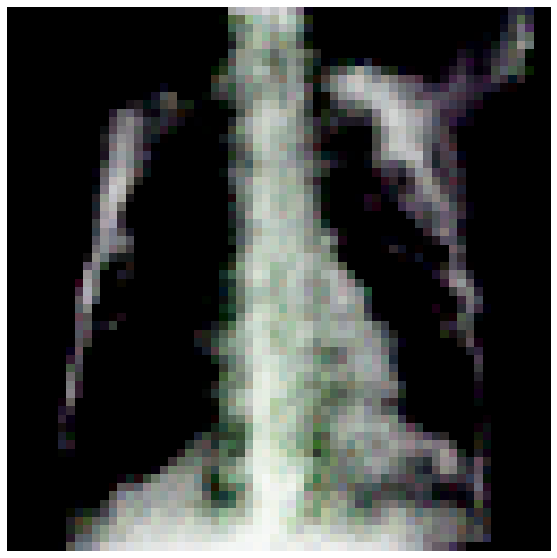

loss_fake: tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1412, de

loss_fake: tensor(0.0815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0987, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [47 / 100] G loss: 8.27078628540039 D loss: 0.017931967973709106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


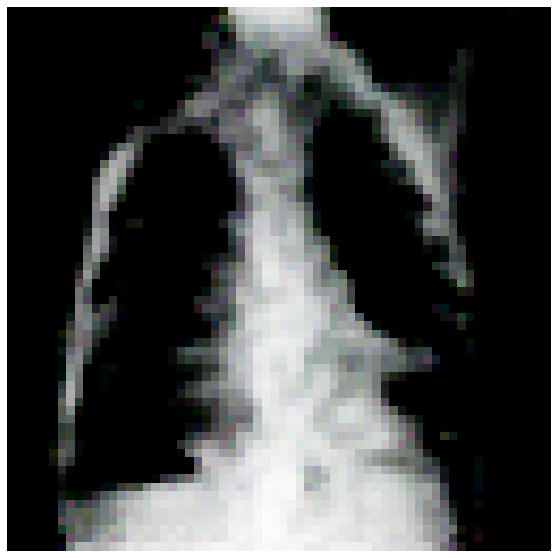

loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, de

loss_fake: tensor(0.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0141, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [48 / 100] G loss: 5.790904998779297 D loss: 0.013280411250889301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


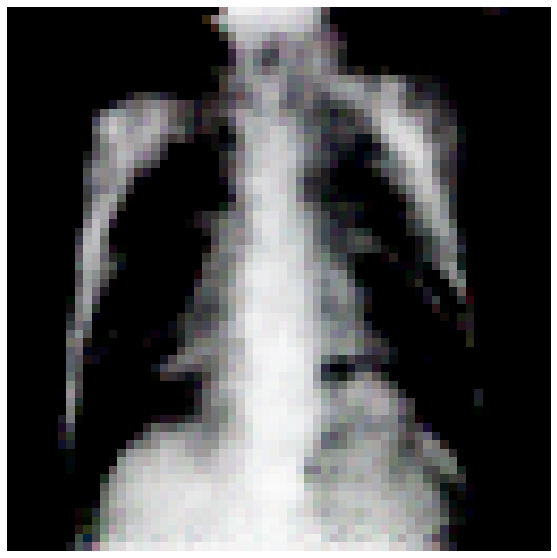

loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.5550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.9426e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3089

loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1006, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [49 / 100] G loss: 5.040336608886719 D loss: 0.05859155207872391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


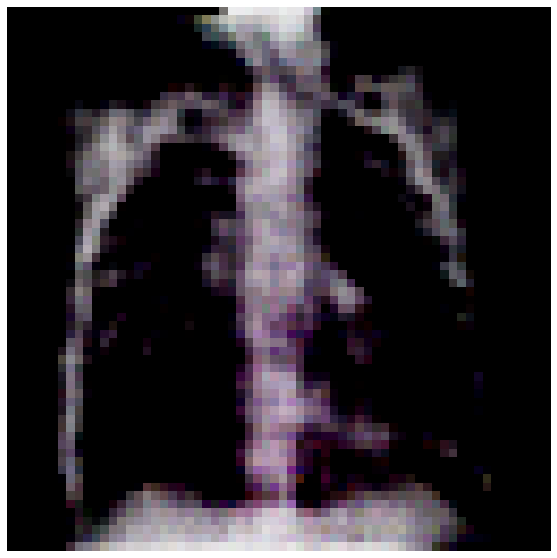

loss_fake: tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, de

loss_fake: tensor(0.0527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [50 / 100] G loss: 5.817922592163086 D loss: 0.06202052906155586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


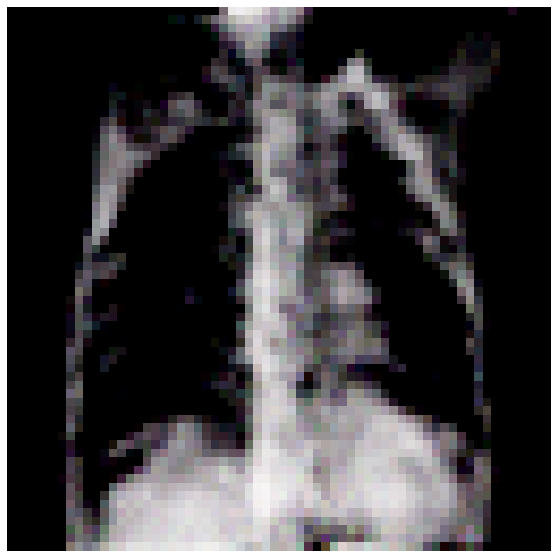

loss_fake: tensor(0.0568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0084, de

loss_fake: tensor(0.3208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [51 / 100] G loss: 5.056387901306152 D loss: 0.08047684282064438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


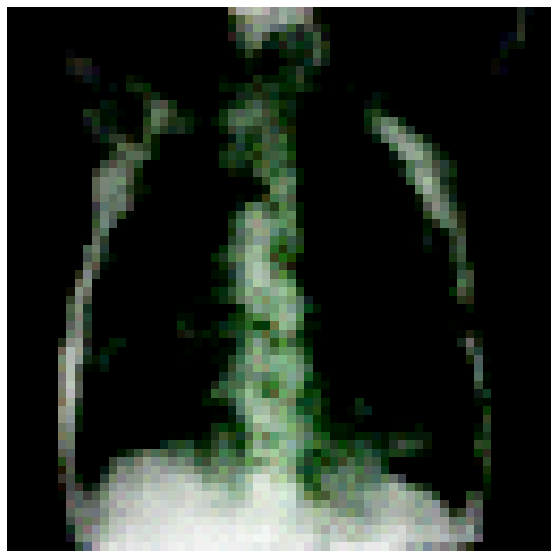

loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0224, de

loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(6.2236e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0920

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [52 / 100] G loss: 6.762971878051758 D loss: 0.00711837550625205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


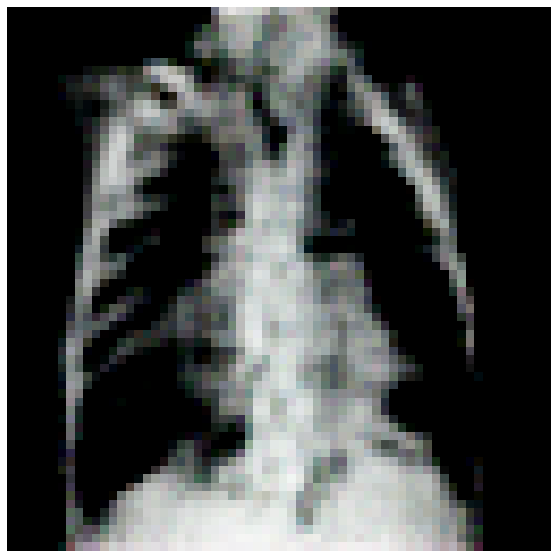

loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0450, de

loss_fake: tensor(0.0282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(9.7482e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.0129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(6.7178e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [53 / 100] G loss: 5.455989837646484 D loss: 0.03851199150085449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


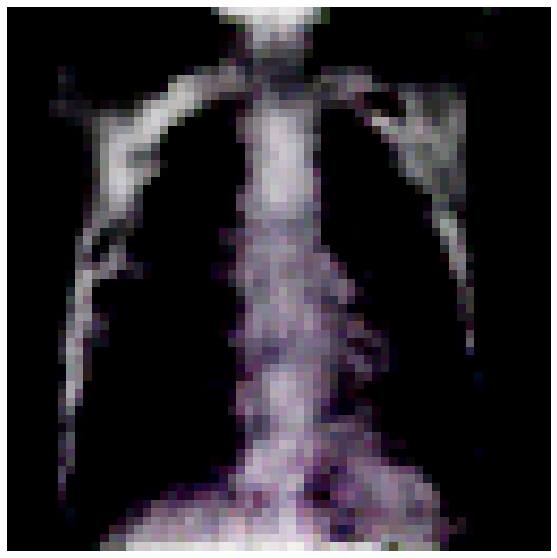

loss_fake: tensor(0.0110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, de

loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [54 / 100] G loss: 6.392177581787109 D loss: 0.12958930432796478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


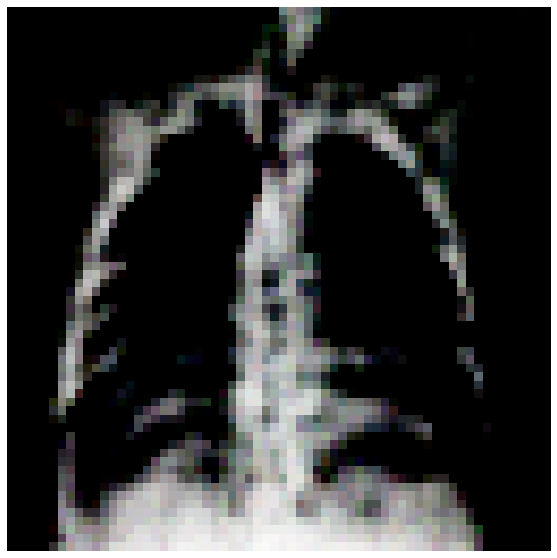

loss_fake: tensor(0.0098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0228, de

loss_fake: tensor(0.2171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(9.7414e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [55 / 100] G loss: 5.813081741333008 D loss: 0.02427854761481285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


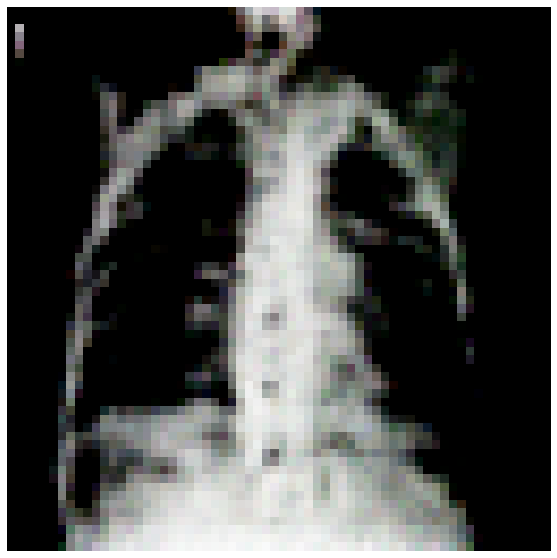

loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0080, de

loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.8458e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [56 / 100] G loss: 3.8414881229400635 D loss: 0.09704211354255676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


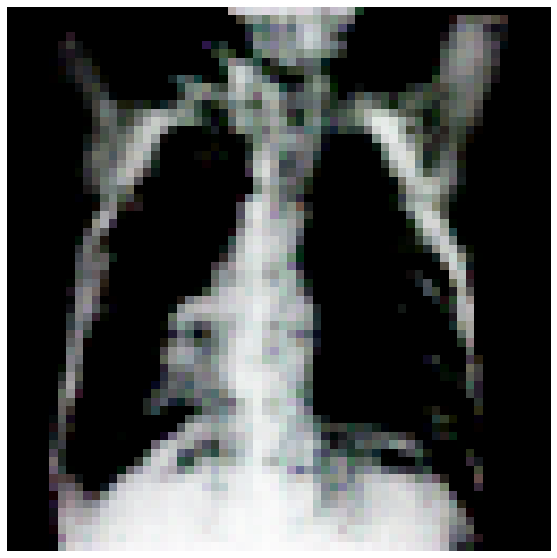

loss_fake: tensor(0.1733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, de

loss_fake: tensor(0.0532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0191, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [57 / 100] G loss: 4.796820640563965 D loss: 0.028262237086892128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


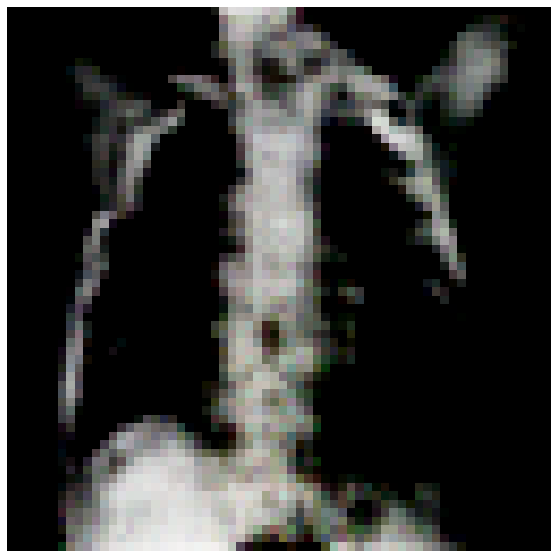

loss_fake: tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0380, de

loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [58 / 100] G loss: 6.538713455200195 D loss: 0.03176603838801384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


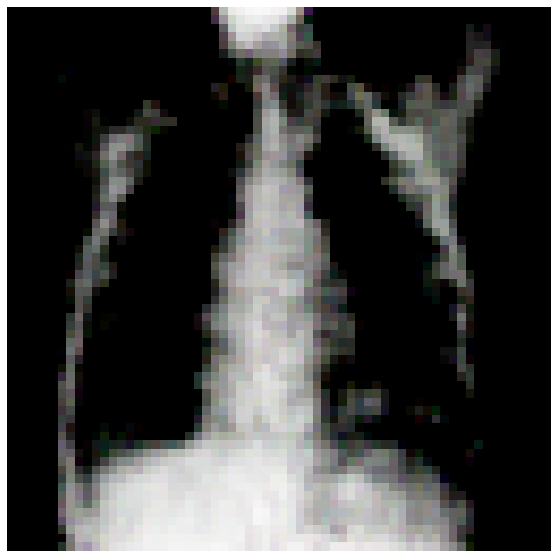

loss_fake: tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, de

loss_fake: tensor(0.0136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(9.9409e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(5.8235e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.7101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [59 / 100] G loss: 5.662270545959473 D loss: 0.011079917661845684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


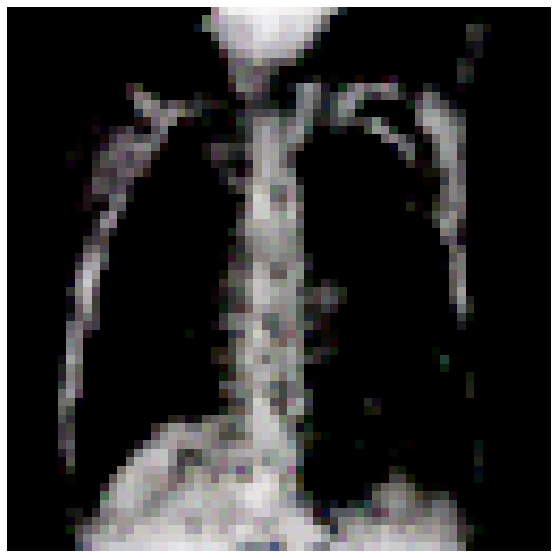

loss_fake: tensor(0.0489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0214, de

loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [60 / 100] G loss: 8.550007820129395 D loss: 0.004530962090939283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


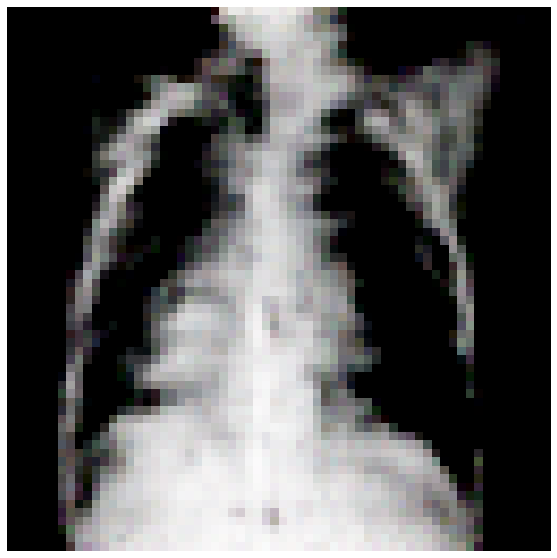

loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.8281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.2595e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.5431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103

loss_fake: tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0250, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [61 / 100] G loss: 6.467332363128662 D loss: 0.021993378177285194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


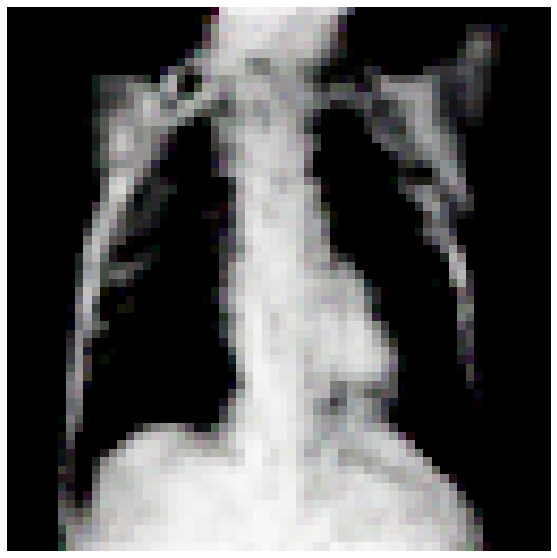

loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.7506e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083

loss_fake: tensor(0.0285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [62 / 100] G loss: 6.384568214416504 D loss: 0.012079346925020218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


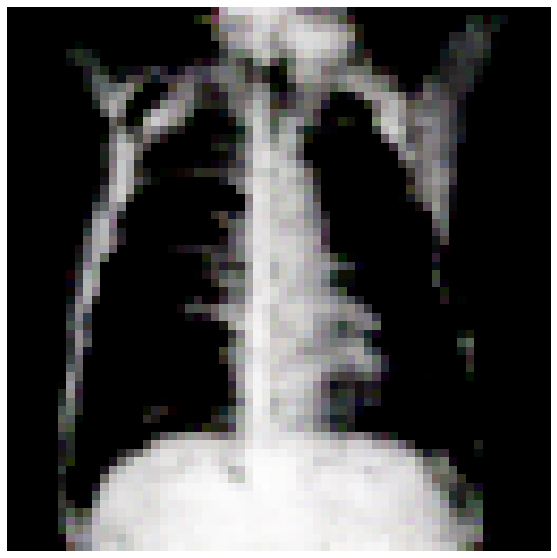

loss_fake: tensor(0.1746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0358, de

loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.4696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.8035e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0236

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [63 / 100] G loss: 8.668822288513184 D loss: 0.0031139827333390713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


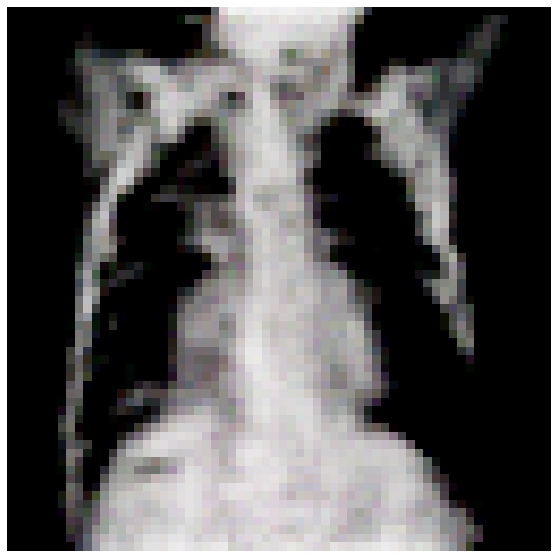

loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, de

loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0311, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [64 / 100] G loss: 5.370800971984863 D loss: 0.05254241079092026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


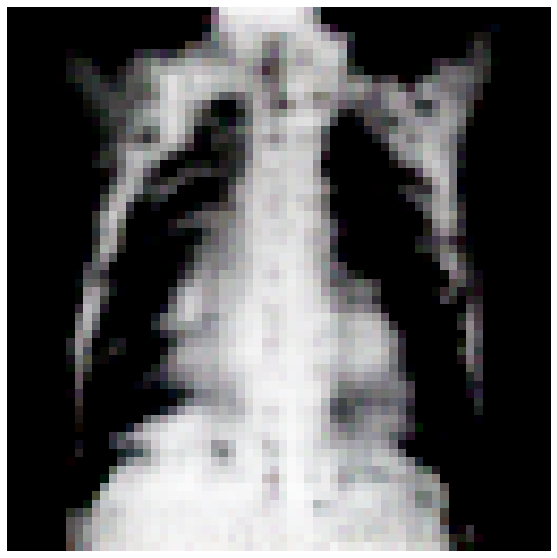

loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, de

loss_fake: tensor(0.0360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [65 / 100] G loss: 4.732126235961914 D loss: 0.04800029098987579


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


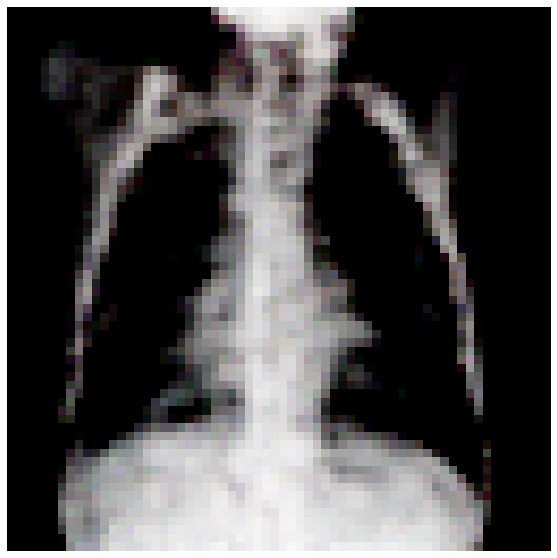

loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0122, de

loss_fake: tensor(0.0364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [66 / 100] G loss: 7.556211471557617 D loss: 0.08747496455907822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


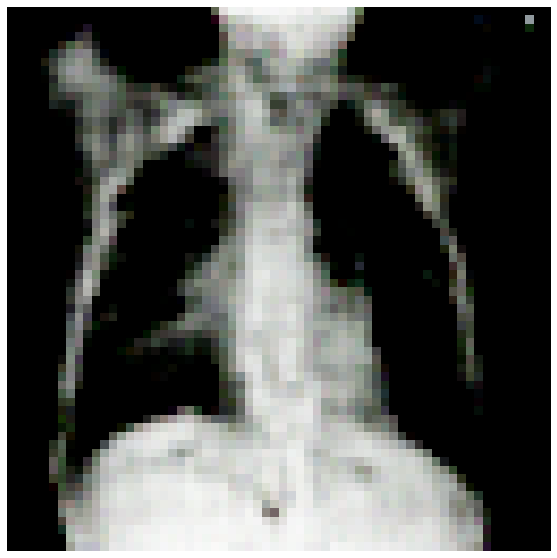

loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, de

loss_fake: tensor(0.0212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0562, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [67 / 100] G loss: 6.435605049133301 D loss: 0.05640118569135666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


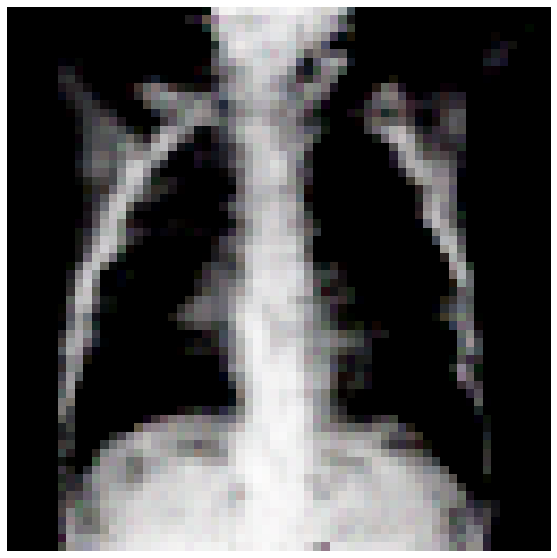

loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, de

loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [68 / 100] G loss: 5.082490921020508 D loss: 0.147622212767601


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


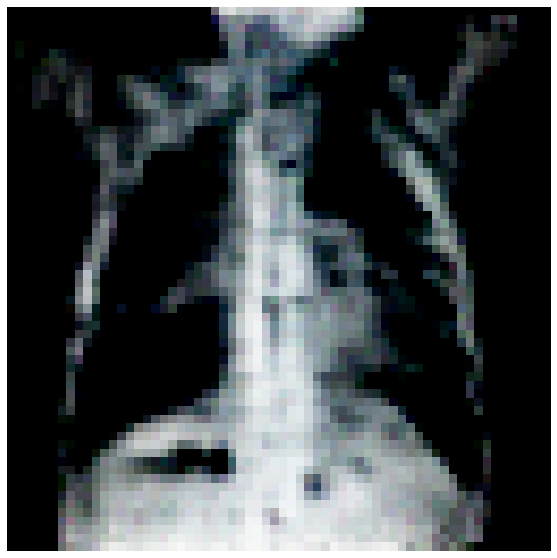

loss_fake: tensor(0.0742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, de

loss_fake: tensor(0.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0348, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [69 / 100] G loss: 4.77345609664917 D loss: 0.020406542345881462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


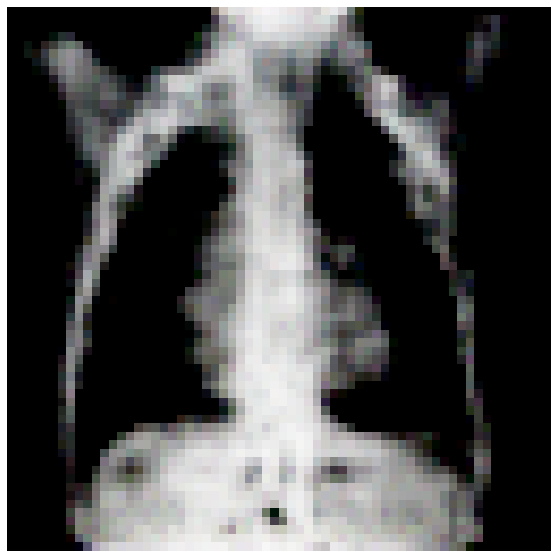

loss_fake: tensor(0.0488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0694, de

loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0710, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [70 / 100] G loss: 7.323305130004883 D loss: 0.00649895379319787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


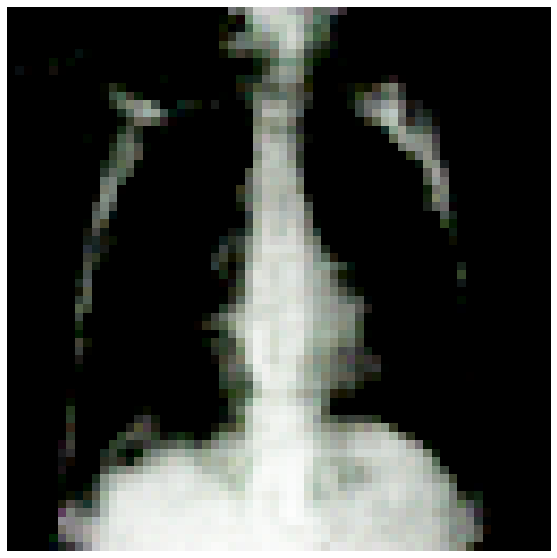

loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(9.7060e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058

loss_fake: tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0190, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [71 / 100] G loss: 8.879007339477539 D loss: 0.06521089375019073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


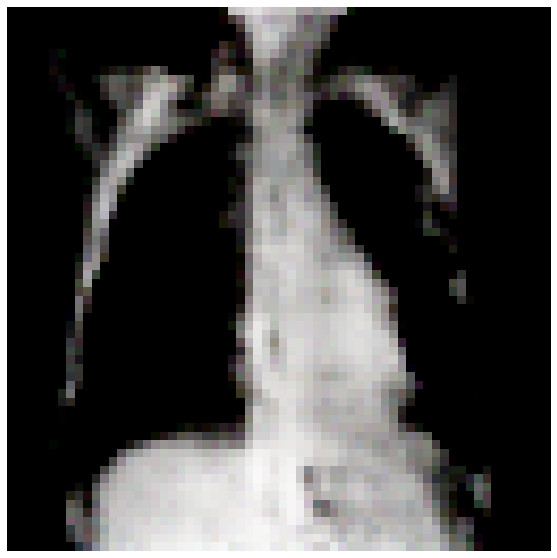

loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, de

loss_fake: tensor(0.0933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.4881e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.0627e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.9413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [72 / 100] G loss: 6.84091854095459 D loss: 0.05820184573531151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


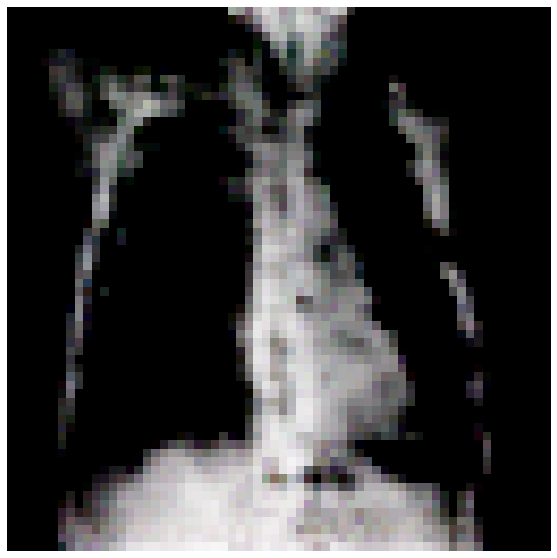

loss_fake: tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0352, de

loss_fake: tensor(0.0593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0357, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [73 / 100] G loss: 7.546260833740234 D loss: 0.05529583990573883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


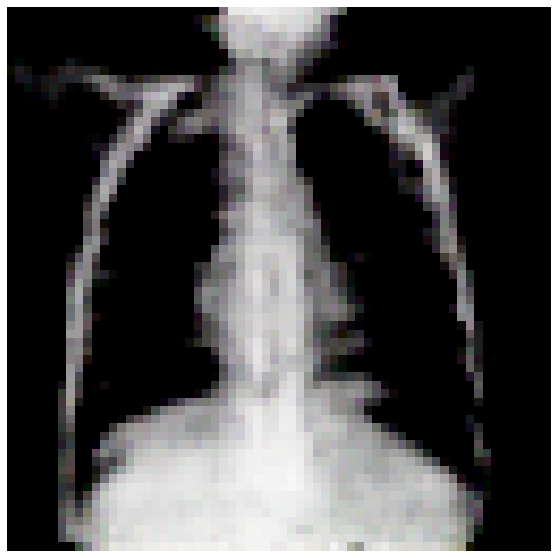

loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.7491e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.6657e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.6458e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.8575e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.6335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: t

loss_fake: tensor(0.3170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [74 / 100] G loss: 4.917219161987305 D loss: 0.06423158198595047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


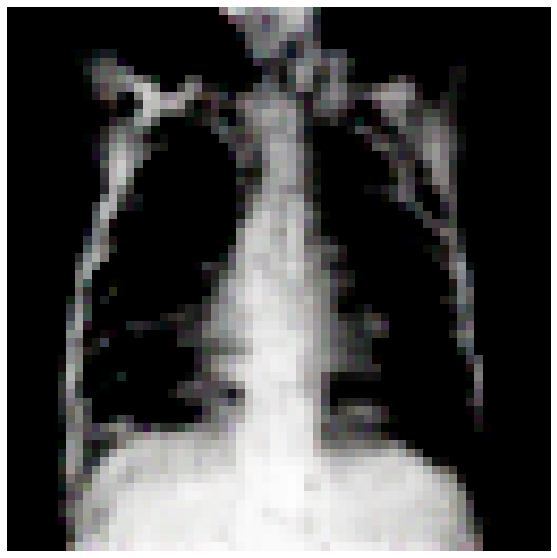

loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(8.0197e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0113

loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0402, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [75 / 100] G loss: 7.547727108001709 D loss: 0.011550374329090118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


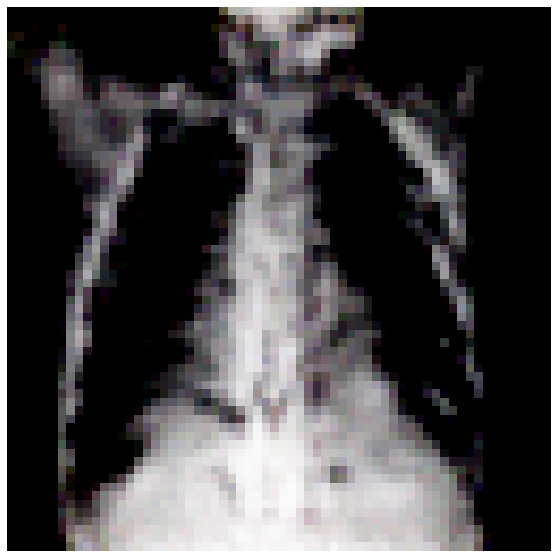

loss_fake: tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, de

loss_fake: tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0389, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [76 / 100] G loss: 0.7718003988265991 D loss: 0.394155889749527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


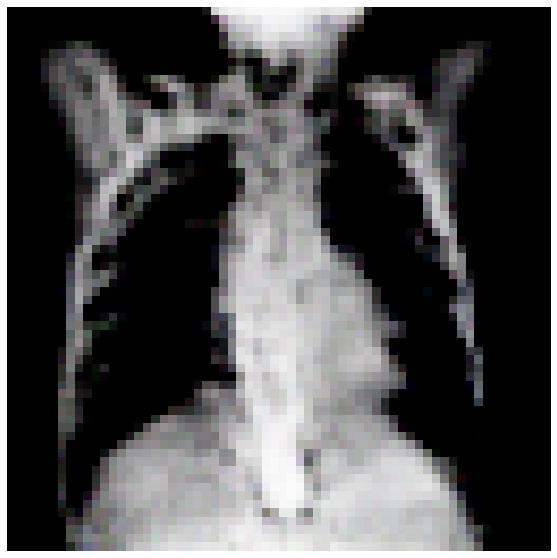

loss_fake: tensor(1.8511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(3.6806e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022

loss_fake: tensor(0.0334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [77 / 100] G loss: 7.39014196395874 D loss: 0.01636088825762272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


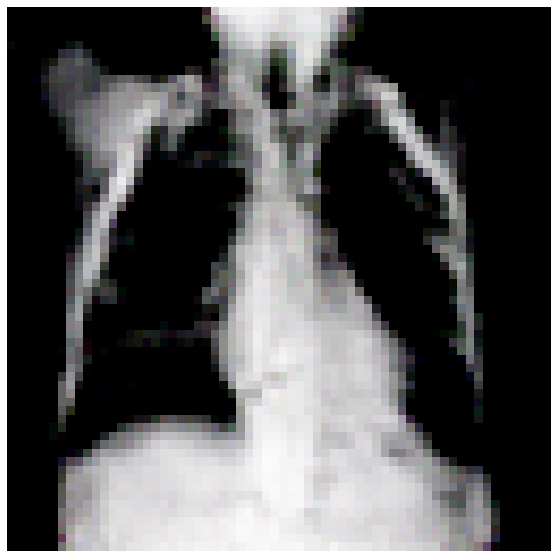

loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0796, de

loss_fake: tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [78 / 100] G loss: 6.655860900878906 D loss: 0.006599009037017822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


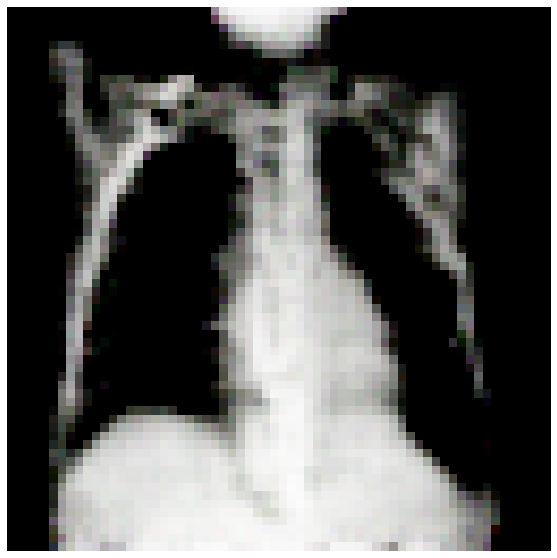

loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, de

loss_fake: tensor(0.0674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [79 / 100] G loss: 5.09934663772583 D loss: 0.02647741325199604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


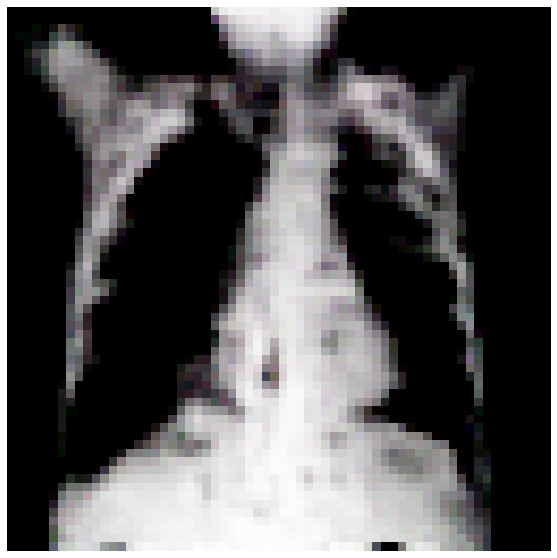

loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0625, de

loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [80 / 100] G loss: 8.121084213256836 D loss: 0.011011737398803234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


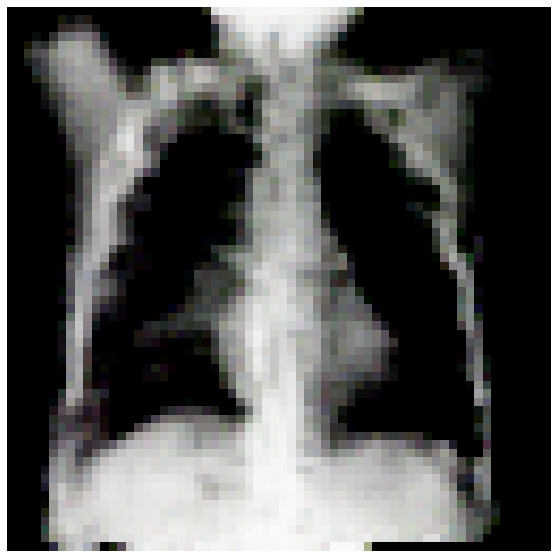

loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, de

loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0601, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [81 / 100] G loss: 7.7678680419921875 D loss: 0.003678384469822049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


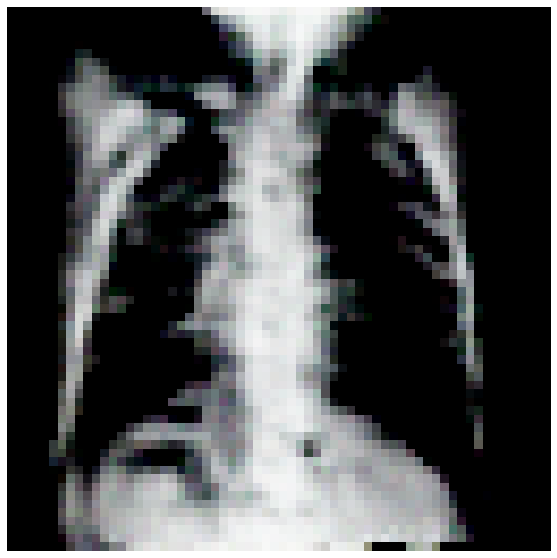

loss_fake: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0460, de

loss_fake: tensor(0.0973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [82 / 100] G loss: 5.21417236328125 D loss: 0.016461694613099098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


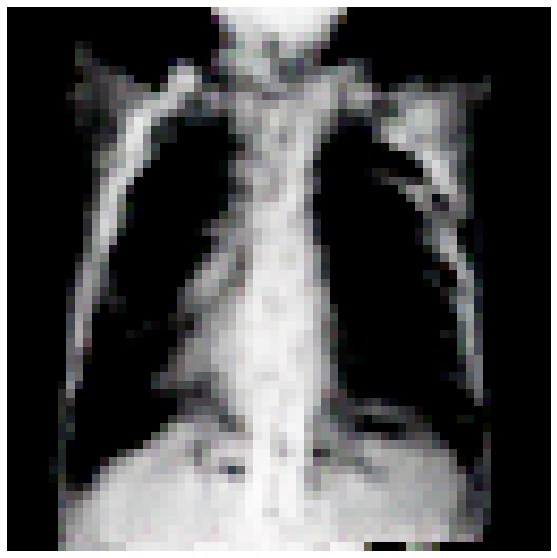

loss_fake: tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0354, de

loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0214, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [83 / 100] G loss: 7.5860748291015625 D loss: 0.001946350559592247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


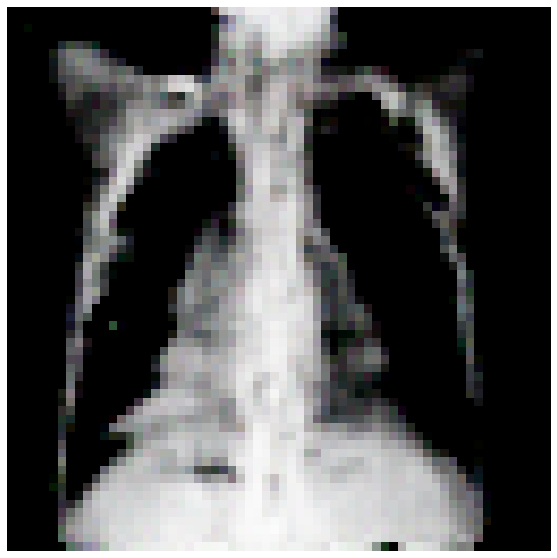

loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(4.6889e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.5243e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(8.1063e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tenso

loss_fake: tensor(0.3954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [84 / 100] G loss: 7.142588138580322 D loss: 0.011155218817293644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


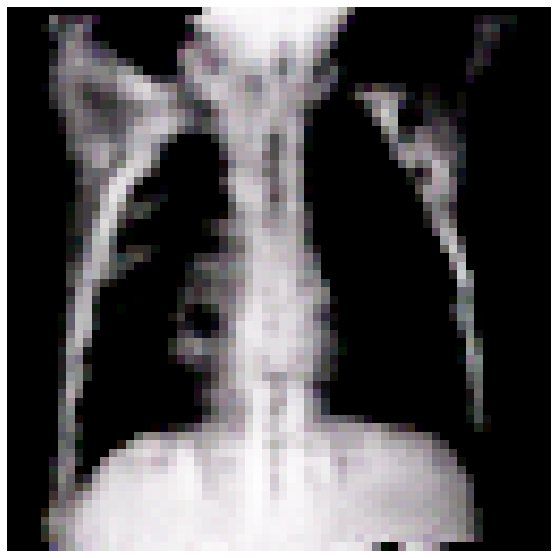

loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0086, de

loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [85 / 100] G loss: 9.26574420928955 D loss: 0.07372985035181046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


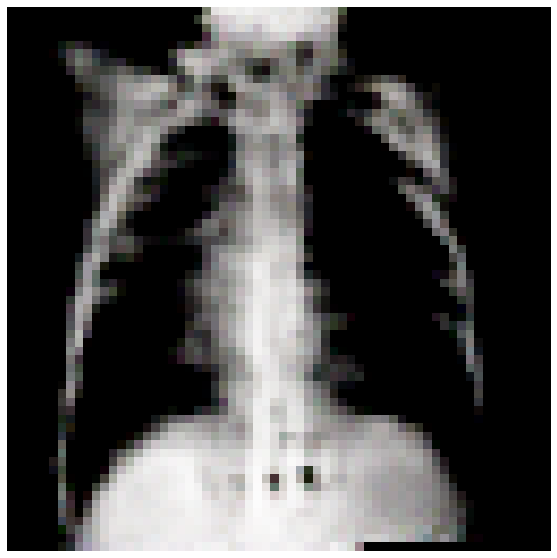

loss_fake: tensor(0.0166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0558, de

loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [86 / 100] G loss: 6.627224922180176 D loss: 0.010006416589021683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


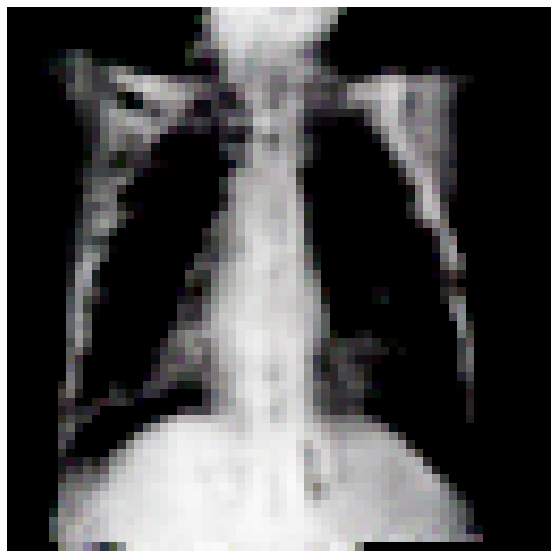

loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0159, de

loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0306, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [87 / 100] G loss: 4.962522983551025 D loss: 0.047902483493089676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


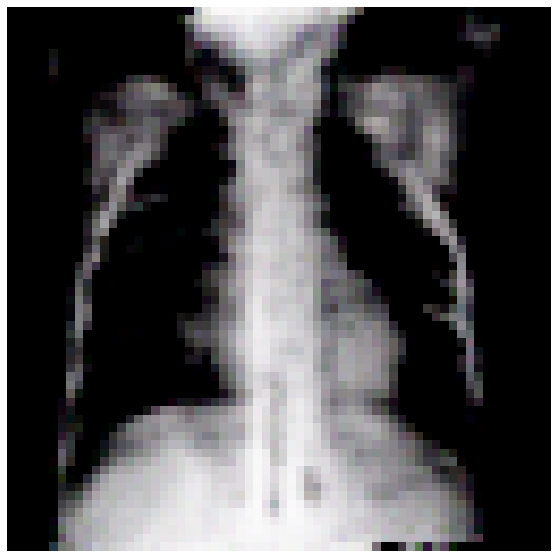

loss_fake: tensor(0.1056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0095, de

loss_fake: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.1891e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0887

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [88 / 100] G loss: 5.984702110290527 D loss: 0.00826468225568533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


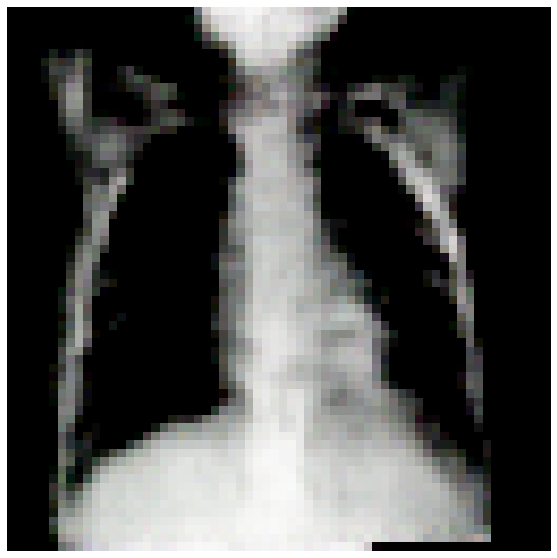

loss_fake: tensor(0.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0047, de

loss_fake: tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.1794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [89 / 100] G loss: 7.505350112915039 D loss: 0.1799423098564148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


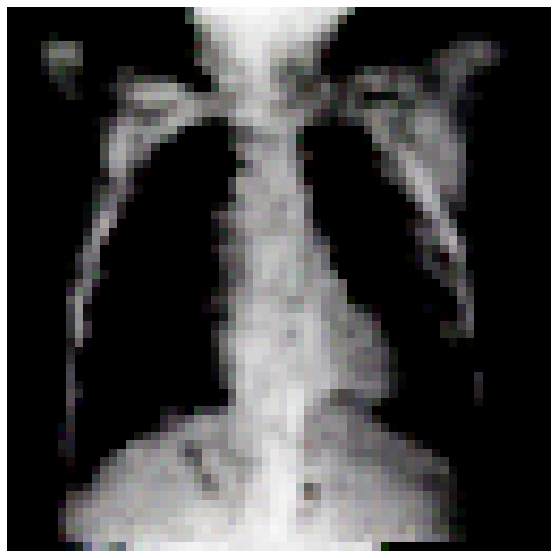

loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0149, de

loss_fake: tensor(0.0212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0130, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [90 / 100] G loss: 6.583806991577148 D loss: 0.03564734384417534


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


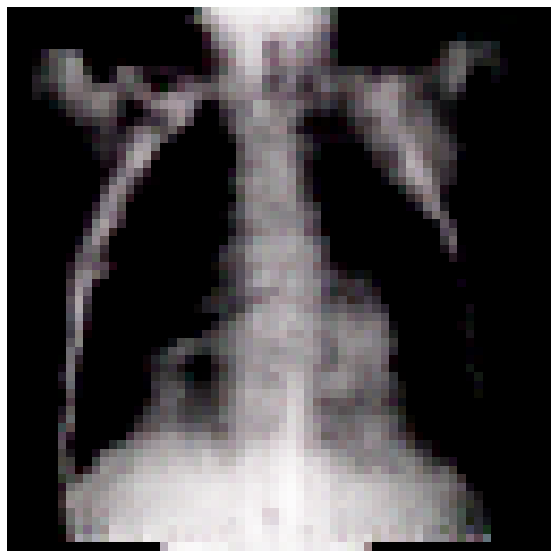

loss_fake: tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, de

loss_fake: tensor(0.0690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [91 / 100] G loss: 5.7309088706970215 D loss: 0.011971844360232353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


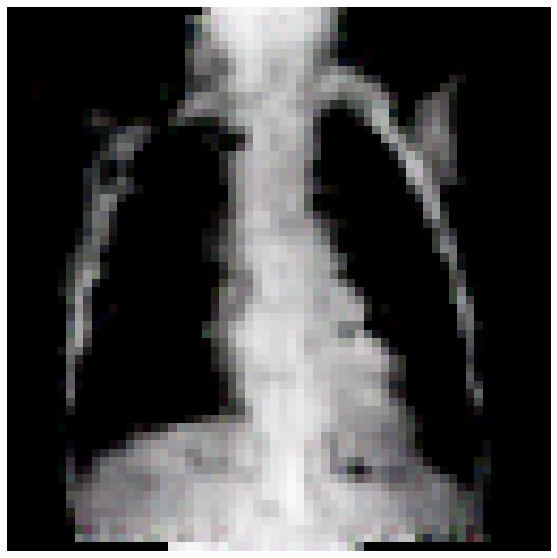

loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(5.9686e-05

loss_fake: tensor(0.0124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0121, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [92 / 100] G loss: 5.421407699584961 D loss: 0.15806187689304352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


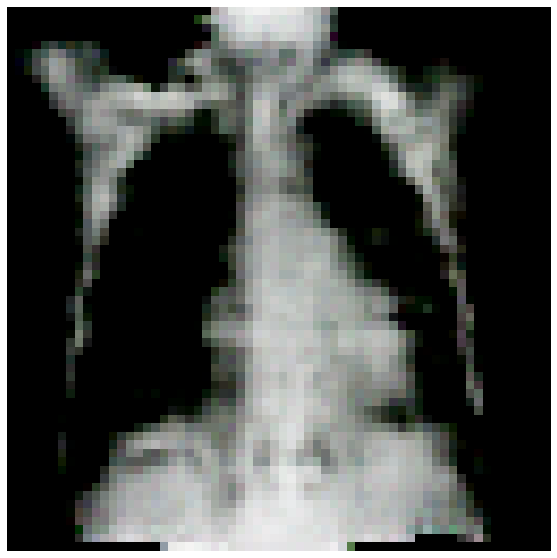

loss_fake: tensor(0.0127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.8557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(6.6401e-06, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0619

loss_fake: tensor(0.0459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [93 / 100] G loss: 5.342615127563477 D loss: 0.05536584556102753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


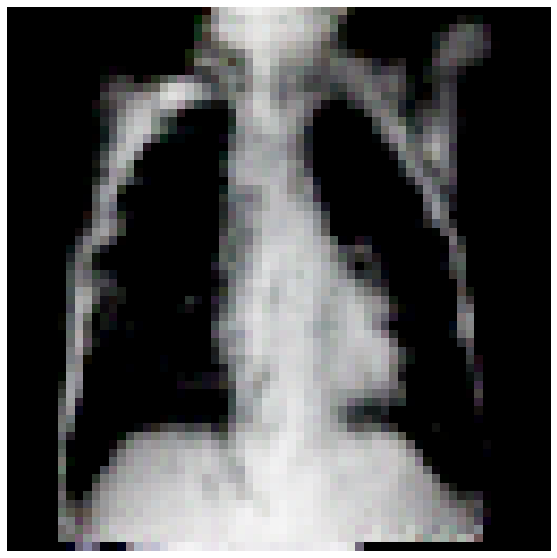

loss_fake: tensor(0.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.7000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.5799e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(2.8430e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [94 / 100] G loss: 1.666466474533081 D loss: 0.6491559147834778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


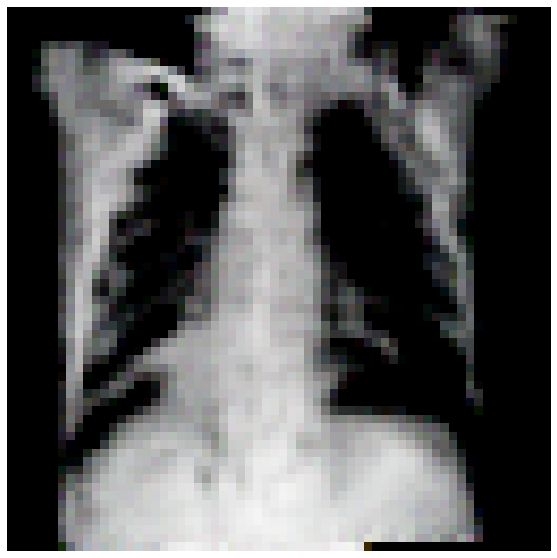

loss_fake: tensor(0.3863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(5.8705e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023

loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [95 / 100] G loss: 6.20347261428833 D loss: 0.010380223393440247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


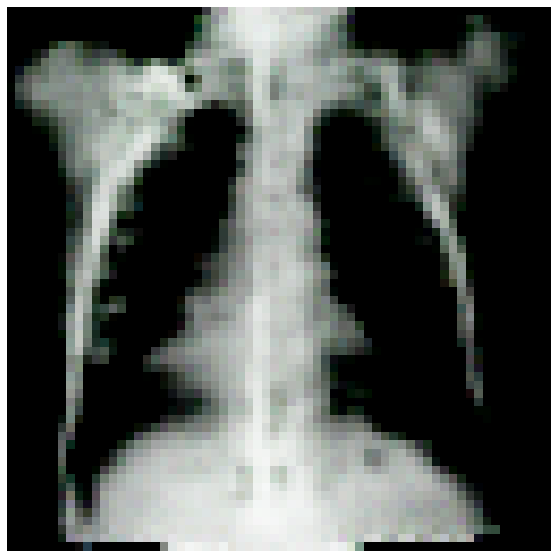

loss_fake: tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.8205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(7.7296e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1156

loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.1034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [96 / 100] G loss: 6.166136741638184 D loss: 0.11026129126548767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


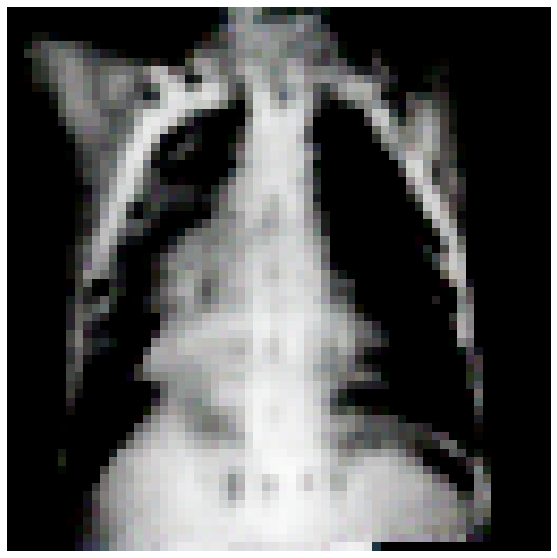

loss_fake: tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1772, de

loss_fake: tensor(0.0420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.1495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [97 / 100] G loss: 8.189297676086426 D loss: 0.15241411328315735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


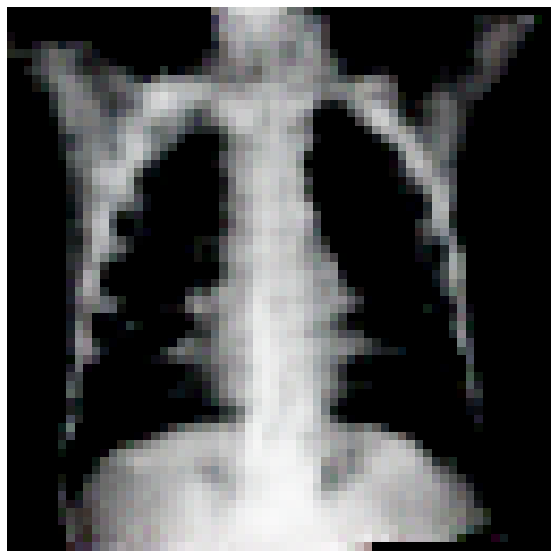

loss_fake: tensor(0.0040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.2401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.1796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0775, de

loss_fake: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.3278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0014, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [98 / 100] G loss: 7.347113132476807 D loss: 0.014921342022716999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


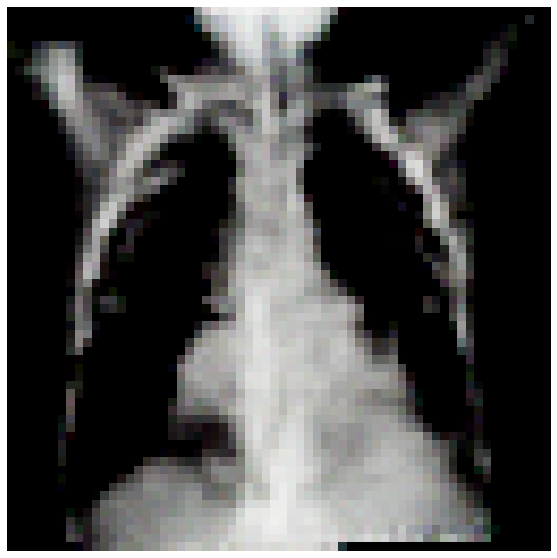

loss_fake: tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0048, de

loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0171, de

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.0042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [99 / 100] G loss: 6.263980865478516 D loss: 0.006604859605431557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


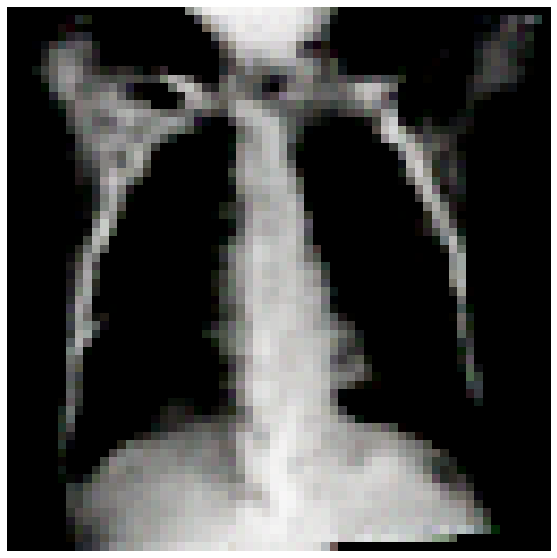

loss_fake: tensor(0.3201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0043, de

loss_fake: tensor(0.0688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(5.6810e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.1418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(1.9584e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.0298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
loss_fake: tensor(0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss_fake: tensor(0.3145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch [100 / 100] G loss: 7.42451286315918 D loss: 0.314515620470047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 2, 0, 2, 2, 1, 1, 0, 2, 1], device='cuda:0')


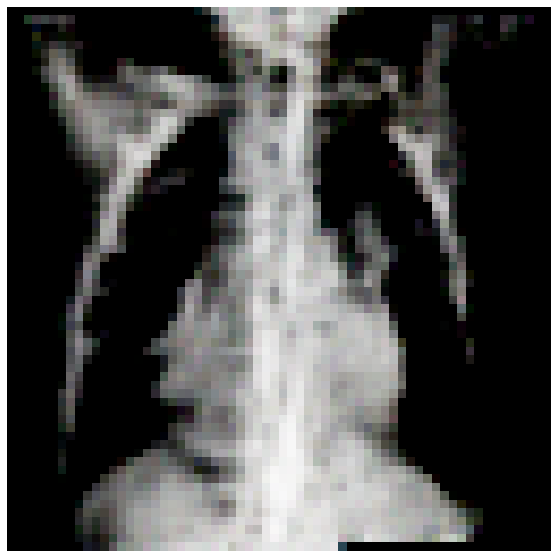

Avg per epoch time: 66.48 sec, total 100 epochs time: 116.24 min
Training finished!
...saving training results


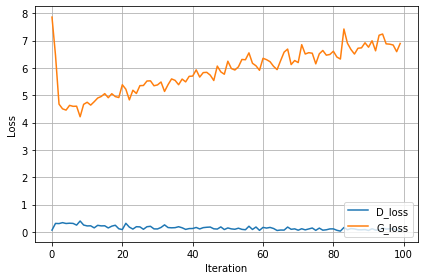

In [27]:
import time
import torch.nn.functional as F
from torchvision import utils
import pickle
import imageio
plt.ion()

# define dataloader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dset_name = 'FAKE_DATA_COVID' #pick a meaningful name
result_dir = '{}_conditional_DCGAN'.format(dset_name)

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
    
device = torch.device("cuda:0")



# define networks
G = Generator().to(device)
# print(G)
D = Discriminator().to(device)
# print(D)

#  define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999)) 

calculatedLoss = nn.BCELoss()

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
count=0

one_hot_labels = torch.FloatTensor(batch_size, 3).cuda()

for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    num_batches = 0
    
    for real, real_labels in data_loader:
        real = real.to(device)
        batch_size = real.size(0)
        
        # generate random latent vector z and random class assignments for each generated image in the minibatch as well as real and fake labels
        real_label = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake_label = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        
        real=Variable(real)
#         print(real.shape)
        labels = Variable(real_labels.type(LongTensor))
        
        D.zero_grad()
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))).view(-1,100,1,1))
        gen_labels = Variable(LongTensor(np.random.randint(0, 3, batch_size)))
        
        
        # generate fakes
        gen_z = G(z,gen_labels)
#         print('gen_z:', gen_z.shape)
        fake_result = D(gen_z,gen_labels).squeeze()
#         print(labels.shape)
        # evaluate fakes
        loss_fake = calculatedLoss(fake_result, fake_label)
#         print('r', real.shape)
#         print('f', gen_z.shape)
        real_result = D(real, labels).squeeze()
        
        # evaluate real minibatch
        loss_real = calculatedLoss(real_result, real_label)
        
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = loss_real + loss_fake
        
        
        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()
        
        gen_z = G(z, gen_labels)
        z_dis = D(gen_z, gen_labels).squeeze()
        
        # train generator to output an image that is classified as real
        G_train_loss = calculatedLoss(z_dis, real_label)
        
        print('loss_fake:', loss_fake)
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()                     

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())
        
        epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_conditional_result( epoch, save=True, show=True, path=result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)
     
end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot loss curves
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# show training progress as animation
images = []
for e in range(num_epochs):
    img_name = result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/conditional_DCGAN_generation_animation.gif', images, fps=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


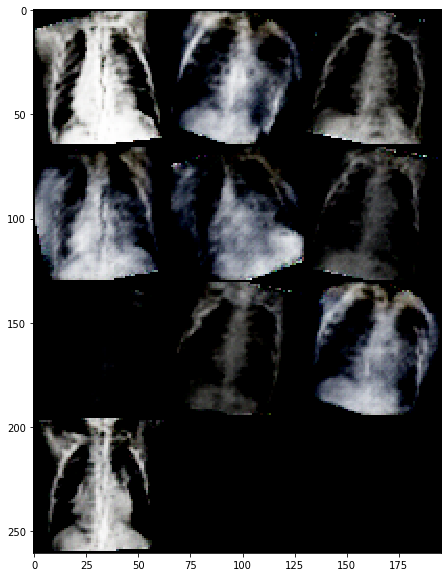

In [28]:
fake = G(fixed_z, fixed_labels).cpu()

fig, ax = plt.subplots(figsize=(20, 10))
image = utils.make_grid(fake.data, n_classes, 1) 

plt.imshow(np.transpose(image, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])

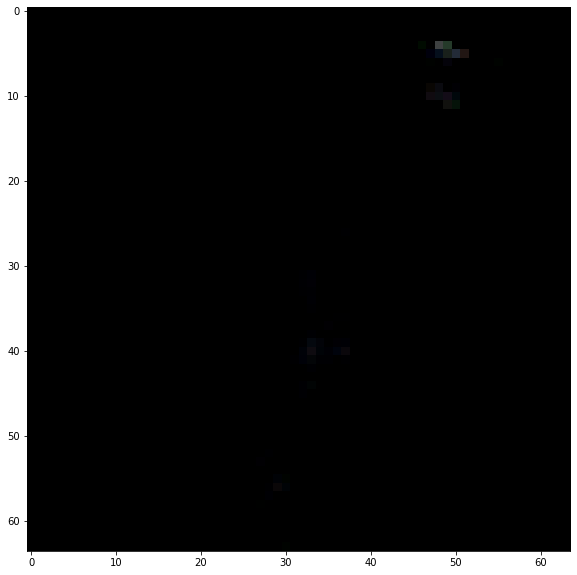

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
image = utils.make_grid(fake[6,:,:,:].data, n_classes, 1) 
plt.imshow(np.transpose(image, (1, 2, 0)))
image.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


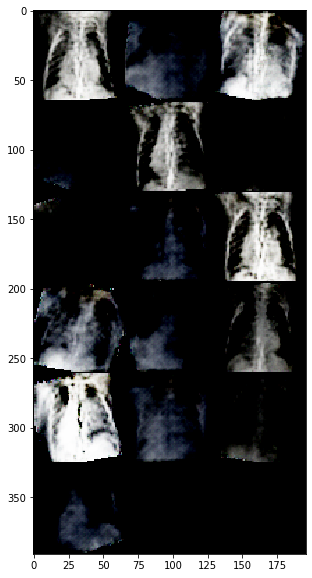

In [30]:
fake = G(z, labels).cpu()

fig, ax = plt.subplots(figsize=(20, 10))
image = utils.make_grid(fake.data, n_classes, 1) 

plt.imshow(np.transpose(image, (1, 2, 0)))

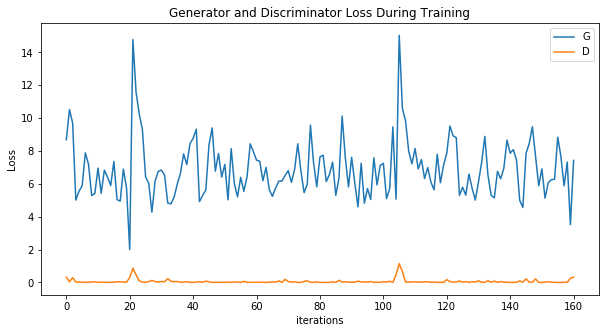

In [31]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
noise = torch.randn(1, nz, 1, 1, device=device)
noise_lab = Variable(LongTensor(np.random.randint(0, 3, 1)))
# Generate fake image batch with G
fake = netG(z, gen_labels) # in real applications, this is the image you want to predict
fake.shape

torch.Size([16, 3, 64, 64])

In [33]:
image = fake.detach().cpu().numpy()
image = utils.make_grid(fake.data, n_classes, 1) 

# plt.imshow(np.transpose(image.detach().cpu(),(1,2,0)))
print(fake[0,:,0,0])

tensor([-0.1068,  0.2091,  0.2297], device='cuda:0', grad_fn=<SelectBackward>)


In [34]:
# Classify all fake batch with D
output = netD(fake, fixed_labels).view(-1)

# image.shape

RuntimeError: Sizes of tensors must match except in dimension 0. Got 10 and 16 (The offending index is 0)

In [ ]:
output

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()